In [1]:
library(repr) ; options(repr.plot.width = 4, repr.plot.height = 4) # Change plot sizes (in cm)

# Model Fitting using Non-linear Least-squares

```{admonition} Learning goals
**By the end of this chapter you should be able to:**
- Recognise biological relationships that require nonlinear functional forms (e.g., Michaelis-Menten, logistic, power laws)
- Fit nonlinear least-squares models using `nls()` in R with appropriate starting values
- Use visual exploration and biological intuition to select sensible starting parameter values
- Assess nonlinear model fit using residual diagnostics, $R^2$-like metrics, and AIC
- Compare alternative nonlinear models (nested and non-nested) to select the best candidate
- Extract biologically meaningful parameters (e.g., asymptotes, half-saturation constants) and their uncertainty
- Communicate nonlinear model results with fitted curves, confidence bands, and parameter tables
```

```{admonition} Prerequisites
:class: tip
**Before starting this chapter, you should:**
- Have covered linear regression foundations (residuals, model fit, interpretation) from [Regression](regress) chapter
- Have some basic calculus intuition (derivatives, minima/maxima concepts) — not required but aids understanding
- Be comfortable reading and manipulating mathematical equations
- Be familiar with common nonlinear functional forms in biology (see chapter introduction or lectures)
```

## Introduction

In this Chapter, you will learn to fit non-linear mathematical models to data using Non-Linear Least Squares (nlls).

Specifically, you will learn to

* Visualize the data and the mathematical model you want to fit to them
* Fit a non-linear model
* Assess the quality of the fit, and whether the model is appropriate for your data
* Compare and select between competing models

We will work through various examples. These assume that you have at least a conceptual understanding of what Linear vs Non-linear models are, how they are fitted to data, and how the fits can be assessed statistically. You may want to see the [Linear Models lecture](https://github.com/mhasoba/TheMulQuaBio/tree/master/content/lectures/LinearModels) (you can also watch the [video](https://drive.google.com/drive/folders/12Sj56wHX6vcAnp9GE9qQ1gIXbn7QrHU2?usp=sharing)), and the [nlls Lecture](https://github.com/mhasoba/TheMulQuaBio/blob/master/content/lectures/nlls) lecture first (you can also watch the [video](https://web.microsoftstream.com/video/529b2560-4f45-4675-ae8b-28487d63ac41)). 

You may also (optionally) want to see the  [lecture on model fitting in Ecology and Evolution in general](https://github.com/mhasoba/TheMulQuaBio/tree/master/content/lectures/ModelFitting). 

We will use r. For starters, clear all variables and graphic devices and load necessary packages:

In [1]:
rm(list = ls())
graphics.off()

## Traits data as an example 

Our first set of examples will focus on traits. 

A trait is any measurable feature of an individual organism. This includes physical traits (e.g., morphology, body mass, wing length), performance traits (e.g., biochemical kinetics, respiration rate, body velocity, fecundity), and behavioral traits (e.g., feeding preference, foraging strategy, mate choice). All natural populations show variation in traits across individuals. A trait is functional when it directly (e.g., mortality rate) or indirectly (e.g., somatic development or growth rate) determines individual fitness. Therefore, variation in (functional) traits can generate variation in the rate of increase and persistence of populations. When measured in the context of life cycles, without considering interactions with other organisms (e.g., predators or prey of the focal population), functional traits are typically called life history traits (such as mortality rate and fecundity). Other traits determine interactions both within the focal population (e.g., intra-specific interference or mating frequency) and between the focal population/species and others, including the species which may act as resources (prey, for example). Thus both life history and interaction traits determine population fitness and therefore abundance, which ultimately influences dynamics and functioning of the wider ecosystem, such as carbon fixation rate or disease transmission rate. 

## Biochemical Kinetics

The properties of an organism's metabolic pathways, and the underlying (enzyme-mediated) biochemical reactions (kinetics) are arguably its most fundamental "traits", because these drive all "performance" traits, from photosynthesis and respiration, to movement and growth rate.

The [Michaelis-Menten](https://en.wikipedia.org/wiki/Michaelis%E2%80%93Menten_kinetics) model is widely used to quantify reaction kinetics data and estimate key biochemical parameters. This model relates biochemical reaction rate ($V$) (rate of formation of the product of the reaction), to concentration of the substrate ($S$):

$$ 
V = \frac{V_{\max} S}{K_M + S} 
$$(eq:M-M)

Here,

* $V_{\max}$ is the maximum rate that can be achieved in the reaction system, which happens at saturating substrate concentration (as $S$ gets really large), and 
* $K_M$ is the Michaelis or half-saturation constant, defined as the substrate concentration at which the reaction rate is half of $V_{\max }$. This parameter controls the overall shape of the curve, i.e., whether $V$ approaches $V_{\max}$ slowly or rapidly. In enzyme catalyzed reactions, it measures how loosely the substrate binds the enzyme: large $K_M$ indicates loose binding of enzyme to substrate, small $K_M$ indicates tight binding (it has units of the substrate concentration, $S$).

Biochemical reactions involving a single substrate are often well fitted by the Michaelis-Menten kinetics.

<img src="./graphics/MM.png" alt="Michaelis-Menten model" width="400px">

<small><center>The Michaelis-Menten model.</center></small>

Let's fit the Michaelis-Menten model to some data. 


### Generating data

Instead of using real experimental data, we will actually *generate* some "data" because that way we know exactly what the errors in the data are. You can also import and use your own dataset for the fitting steps further below.

We can generate some data as follows.

First, generate a sequence of substrate concentrations from 1 to 50 in jumps of 5, using `seq()` (look up the documentation for `seq()`).

In [2]:
S_data <- seq(1,50,5)
S_data

[1]  1  6 11 16 21 26 31 36 41 46

Note that because we generated values only at intervals of, there will be 50/5 = 10 "substrate" values.

Now generate a Michaelis-Menten reaction  velocity response with `V_max` = 12.5 and `K_M` = 7.1:

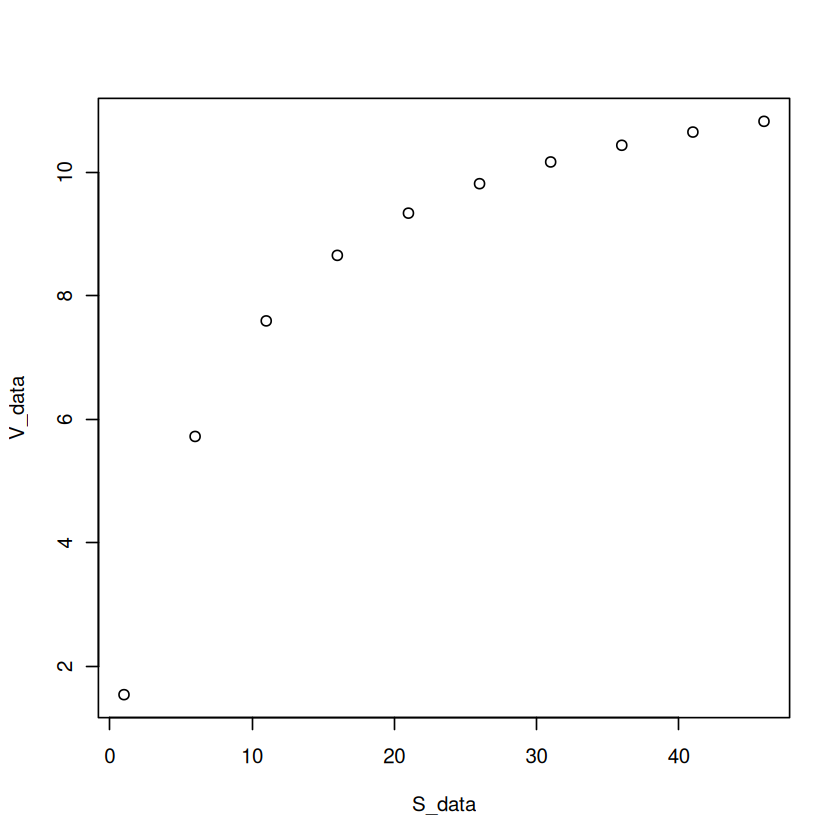

In [3]:
V_data <- ((12.5 * S_data)/(7.1 + S_data))
plot(S_data, V_data)

Note that our choice of $V_{\max} = 12.5$ and $K_M = 7.1$ is completely arbitrary. As long as we make sure that $V_{\max} > 0$, $K_H > 0$, and $K_M$ lies well within the lower half of the the range of substrate concentrations (0-50), these "data" will be physically biologically sensible.

Now let's add some random (normally-distributed) fluctuations to the data to emulate experimental / measurement error:

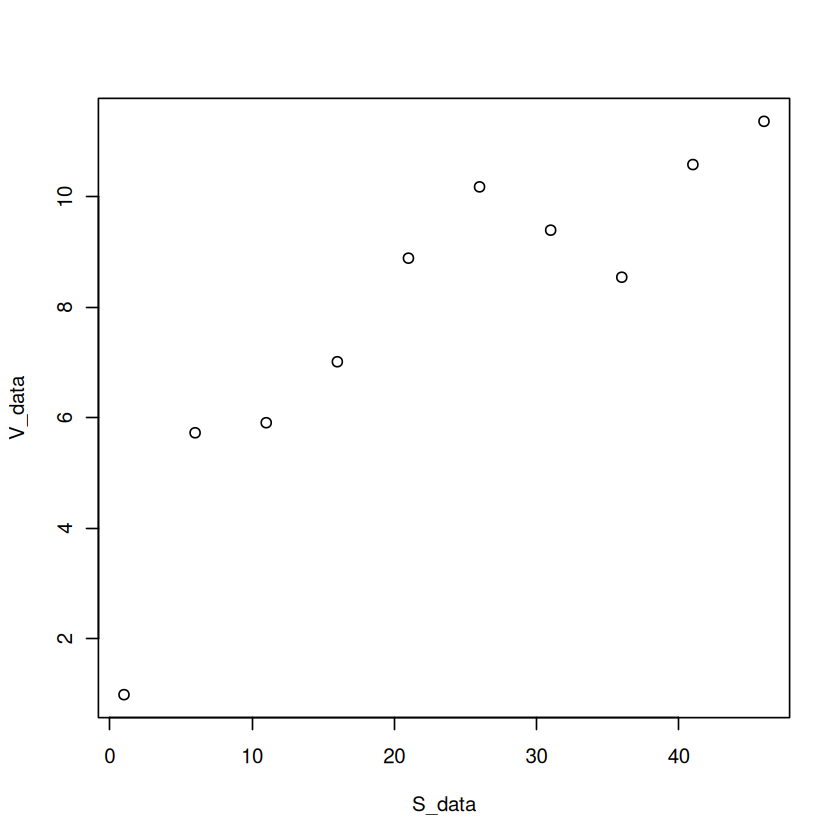

In [4]:
set.seed(1456) # To get the same random fluctuations in the "data" every time
V_data <- V_data + rnorm(10,0,1) # Add 10 random fluctuations  with standard deviation of 1 to emulate error
plot(S_data, V_data)

That looks real!

## Fitting the model using nlls

Now, fit the model to the data:

In [5]:
MM_model <- nls(V_data ~ V_max * S_data / (K_M + S_data))

Warning message in nls(V_data ~ V_max * S_data/(K_M + S_data)):
“No starting values specified for some parameters.
Initializing ‘V_max’, ‘K_M’ to '1.'.
Consider specifying 'start' or using a selfStart model”


This warning arises because `nls` requires "starting values" for the parameters (two in this case: `V_max` and `K_M`) to start searching for optimal combinations of parameter values (ones that minimize the rSS). Indeed, all nlls fitting functions / algorithms require this. If you do not provide starting values, `nls` gives you a warning (as above) and uses a starting value of 1 for every parameter by default. For simple models, despite the warning, this works well enough.

```{tip}
Before proceeding further, have a look at what `nls()`'s arguments are using `?nls`, or looking at the documentation [online](https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/nls).
```

We will address the issue of starting values soon enough, but first let's look at how good the fit that we obtained looks.

### Visualizing the fit 

The first thing to do is to see how well the model fitted the data, for which plotting is the best  first option:

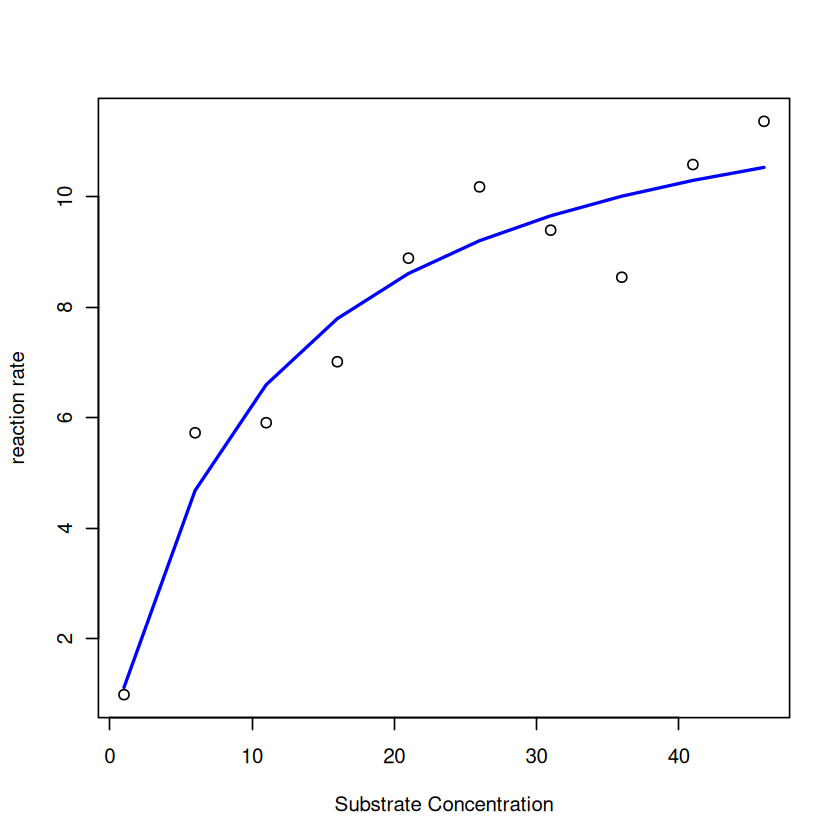

In [6]:
plot(S_data,V_data, xlab = "Substrate Concentration", ylab = "reaction rate")  # first plot the data 
lines(S_data,predict(MM_model),lty=1,col="blue",lwd=2) # now overlay the fitted model 

This looks OK. 

```{note}
We used the `predict()` function here just as we did in any of the linear models chapters (e.g., [here](MulExp:Predicted-values)). In general, you can use most of the same commands/functions (e.g., `predict()` and `summary()`) on the output of a `nls()` model fitting object as you would on a `lm()` model fitting object. Please have a look at the [documentation](https://stat.ethz.ch/r-manual/r-devel/library/stats/html/predict.nls.html) of the predict function for `nls` before proceeding.   
```

However, the above approach for plotting is not the best way to do it, because `predict()`, without further arguments (see its [documentation](https://stat.ethz.ch/r-manual/r-devel/library/stats/html/predict.nls.html)), by default only generates predicted values for the actual x-values (substrate) data used to fit the model. So if there are very few values in the original data, you will not get a smooth predicted curve (as you can see above). A better approach is to generate a sufficient number of x-axis values and then calculate the predicted line. Let's do it:

In [7]:
coef(MM_model) # check the coefficients

V_max      K_M 
12.96369 10.60723

In [8]:
Substrate2Plot <- seq(min(S_data), max(S_data),len=200) # generate some new x-axis values just for plotting

In [9]:
Predict2Plot <- coef(MM_model)["V_max"] * Substrate2Plot / (coef(MM_model)["K_M"] + Substrate2Plot) # calculate the predicted values by plugging the fitted coefficients into the model equation 

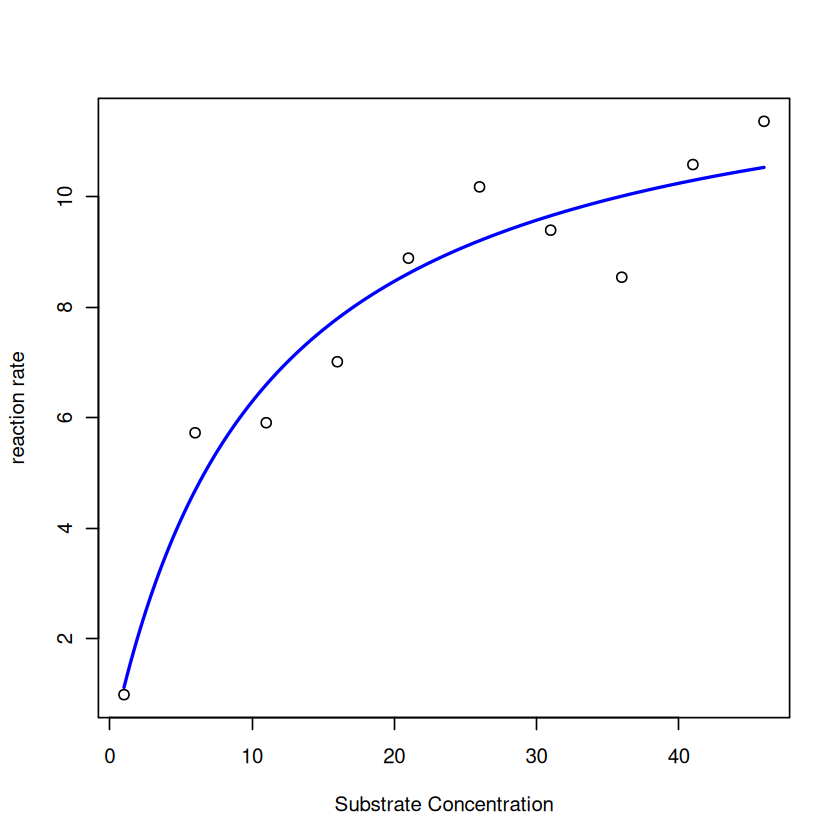

In [10]:
plot(S_data,V_data, xlab = "Substrate Concentration", ylab = "reaction rate")  # first plot the data 
lines(Substrate2Plot, Predict2Plot, lty=1,col="blue",lwd=2) # now overlay the fitted model

That looks much better (smoother) than the plot above !

### Summary stats of the fit

Now lets get some stats of this nlls fit. Having obtained the fit object (`MM_model`), we can use `summary()` just like we would for a `lm()` fit object: 

In [11]:
summary(MM_model)


Formula: V_data ~ V_max * S_data/(K_M + S_data)

Parameters:
      Estimate Std. Error t value Pr(>|t|)    
V_max   12.964      1.221  10.616 5.42e-06 ***
K_M     10.607      3.266   3.248   0.0117 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8818 on 8 degrees of freedom

Number of iterations to convergence: 5 
Achieved convergence tolerance: 9.535e-06


This looks a lot like the output of a linear model, and to be specific, of a [Linear regression](./regress.ipynb). For starters, compare the above output with the output of `summary(genomeSizeModelDragon)` in [this section](regress:perform) of the Linear regression chapter. 

So here are the main things to note about the output of `summary()` of an `nls()` model object:

* `Estimate`s are, as in the output of the `lm()` function for fitting linear models, the estimated values of the coefficients of the model that you fitted ($V_{\max}$ and $K_M$). Note that although we generated our data using $V_{\max} = 12.5$ and $K_M = 7.1$, the actual coefficients are quite different from what we are getting with the nlls fitting ($\hat{V}_{\max} = 12.96$ and $\hat{K}_M = 10.61$). This is because we added random (normally-distributed) errors when we generated the "data". This tells you something about how experimental and/or measurement errors can distort your image of the underlying mechanism or process.   
* `Std. Error`, `t value`, and `Pr(>|t|)` and `residual standard error` have the same interpretation as in the output of `lm()` (please look back at the [Linear regression Chapter](./regress.ipynb))
* `Number of iterations to convergence` tells you how many times the nlls algorithm had to adjust the parameter values till it managed to find a solution that minimizes the residual Sum of Squares (rSS)
* `Achieved convergence tolerance` tells you on what basis the algorithm decided that it was close enough to the a solution; basically if the rSS does not improve more than a certain threshold despite parameter adjustments, the algorithm stops searching. This may or may not be close to an optimal solution (but in this case it is).

The last two items are specific to the output of an `nls()` fitting `summary()`, because unlike Ordinary Least Squares (OLS), which is what we used for Linear regression, nlls is not an *exact* procedure, and the fitting requires computer simulations; revisit the [Lecture](https://github.com/mhasoba/TheMulQuaBio/tree/master/content/lectures/nlls) for an explanation of this. This is all you need to know for now. As such, you do not need to report these last two items when presenting the results of an nlls fit, but they are useful for problem solving in case the fitting does not work (more on this below). 

As noted above, you can use the same sort of commands on a `nls()` fitting result as you can on a `lm()` object.  

Thus, much of the output of nlls fitting using `nls()` is similar to the output of an `lm()`, and can be further analyzed or processed using analogous functions such as `coef()`, `residuals()`, and `confint()`. 

For example, you can get just the values of the estimated coefficients using `coef()` as you did above for the plotting.   

## Statistical inference using nlls fits

So what do we do with the results of an nlls fit? What statistical inferences can be made? We will address this issue here at a basic level, and then revisit it using model selection further below (in the Allometric growth example).

### Goodness of fit

Assessing whether an nlls-fitted model is "significant" based on an F-value, by performing an Analysis of Variance (anova) on the regression results as one can do for a Linear Model using the [`anova()` function on a linear model fit](regress:perform) is not advisable. Try `anova(MM_model)`, and see what happens:

In [12]:
anova(MM_model)

ERROR: Error in anova.nls(MM_model): anova is only defined for sequences of "nls" objects


So a anova calculation is not implemented for a nlls fit. The third item in the error message / traceback above says that you can however use `anova()` to compare two *nested* models. That is, you can do something like `anova(model1,model2)`, where model 1 is nested within model 1, as we did [previously](./regress.ipynb) to ask if a simpler model explains significantly more variation in the data than a more complicated one (with one or more addtional terms in the equation).

To understand why you cannot use an anova to assess the significance of a nlls model fit, recall that the objective of an [`anova()` function applied to  a linear model fit](regress:perform) is o compare the fitted model to a *null* model, asking whether you can reject that null model (hypothesis). The problem with doing so for a nonlinear model is that unfortunately it is not clear what the null hypothesis should be when the model is not a linear combination of terms (the definition of a linear model). For an F-statistic to be meaningful, the null hypothesis model must be nested *within* the alternative model (in which case you can indeed use the `anova()` function using `anova(Model1,Model2)`). 

To make this clear, let's recall the equation for a simple linear regression:

$$y = \beta_0 + \beta_1 x$$

The null model for this is 

$$y = \beta_0$$

This then allows the TSS, rSS and ESS to be calculated in a meaninglful way, as we [did before](./regress.ipynb), leading to an anova based assessment of significance of the regrssion moel fit to the data. 

Now consider a nonlinear model like the Michaelis-Menten eqn {eq}`eq:M-M`. *What would be an appropriate null model for this equation?*

Thus, the best ways to assess a nlls model's fit are:

* Compare it's likelihood to those of other alternative models' fits (which may include your best guess for a null model).

* Examine whether the fitted coefficients are reliable, i.e., are significant, based on their (low) standard errors, (high) t-values, and (low) p-values (see the example model's summary above).

#### r-squared values

To put it simply, unlike an r$^2$ value obtained by fitting a linear model, that obtained from nlls fitting is not reliable, and should not be used. The reason for this is somewhat technical (e.g., see this [paper](https://dx.doi.org/10.1186%2F1471-2210-10-6)) and we won't go into it here. But basically, nlls r$^2$ values do not always accurately reflect the quality of fit, and definitely cannot be used to select between competing models (Model selection, as you learned [previously](./model-simp.ipynb)). Indeed r$^2$ values obtained from nlls fitting even be negative when the model fits very poorly! We will learn more about model selection with non-linear models later below.

### Confidence Intervals 

One particularly useful thing you can do after nlls fitting is to calculate/construct the confidence intervals (CI's) around the estimated parameters in our fitted model. This is analogous to how we would in the OLS fitting used for Linear Models: 

In [13]:
confint(MM_model)

Waiting for profiling to be done...



,2.5%,97.5%
V_max,10.640478,17.00502
K_M,4.924547,22.39247


The `Waiting for profiling to be done...` message reflects the fact that calculating the standard errors from which the CI's are calculated requires a particular computational procedure (which we will not go into here) when it comes to nlls fits. 

Calculating confidence intervals can be useful because, 

1. As you learned [here](t_f_tests:CI), [here](t_f_tests:CI2), and [here](anova:CI) (among other places) you can use a coefficient/parameter estimate's confidence intervals to test whether it is significantly different from some reference value. In our CI example above, the intervals for `K_M` do in fact include the original value of $K_M = 7.1$ that we used to generate the data.

2. Confidence intervals can also be used to do a quick (but not robust - see warning below) test of whether coefficient estimates of the same model coefficient obtained from different populations (samples) are significantly different from each other (If their CI's don't overlap, they are significantly different).

```{warning}
You can compare estimates of the same coefficient (parameter) from samples of different populations: if their CI's don't overlap, this indicates a statistically significant difference between the two populations as far as that coefficient is concerned (e.g., for 95% CI's this means at the 0.05 level of significance or p-value). However, the opposite is not necessarily true: when CI's overlap, there may *still* be a statistically significant difference between the coefficients (and therefore, populations).
```

## The starting values problem

Now let's revisit the issue of starting values in nlls fitting. Previously, we fitted the Michaelis-Menten Model without any starting values, and r gave us a warning but managed to fit the model to our synthetic "data" using default starting values. 

### Fitting the model with starting values

Lets try the nlls fitting again, but with some particular starting values:

In [14]:
MM_model2 <- nls(V_data ~ V_max * S_data / (K_M + S_data), start = list(V_max = 12, K_M = 7))

Note that unlike before, we got no warning message about starting values.

*As will become apparent below, using sensible starting values is important in nlls fitting.*

```{note}
*How do you find "sensible" starting values for nlls fitting?* This very much depends on your understanding of the mathematical model that is being fitted to the data, the mechanistic interpretation of its parameters, and the specific dataset. For example, in the Michaelis-Menten Model example, we can know that $V_{\max}$ is maximum reaction velocity and $K_M$ is the value of the substrate concentration at which half of $V_{\max}$ is reached. So we can choose starting values by "eye-balling" a particular dataset and determining *approximately* what the `V_max`and `K_M` are be for that particular dataset. In this particular case, we chose `V_max` = 12 and `K_M` = 7 because looking at the data plot above, these values seem to be reasonable guesses for the two parameters.   
```


Let's compare the coefficient estimates from our two different model fits to the same dataset:

In [15]:
coef(MM_model)
coef(MM_model2)

V_max      K_M 
12.96369 10.60723

V_max      K_M 
12.96363 10.60706

Not too different, but not exactly the same! 

In contrast, when you fit linear models you will get exactly the same coefficient estimates every single time, because OLS is an *exact* procedure.

Now, let's try even more different start values:

In [16]:
MM_model3 <- nls(V_data ~ V_max * S_data / (K_M + S_data), start = list(V_max = .01, K_M = 20))

Compare the coefficients of this model fit to the two previous ones: 

In [17]:
coef(MM_model)
coef(MM_model2)
coef(MM_model3)

V_max      K_M 
12.96369 10.60723

V_max      K_M 
12.96363 10.60706

V_max         K_M 
  0.8161299 -19.4993656

The estimates in our latest model fit are completely different (in fact, `K_M` is negative)! Let's plot this model's and the first model's fit together: 

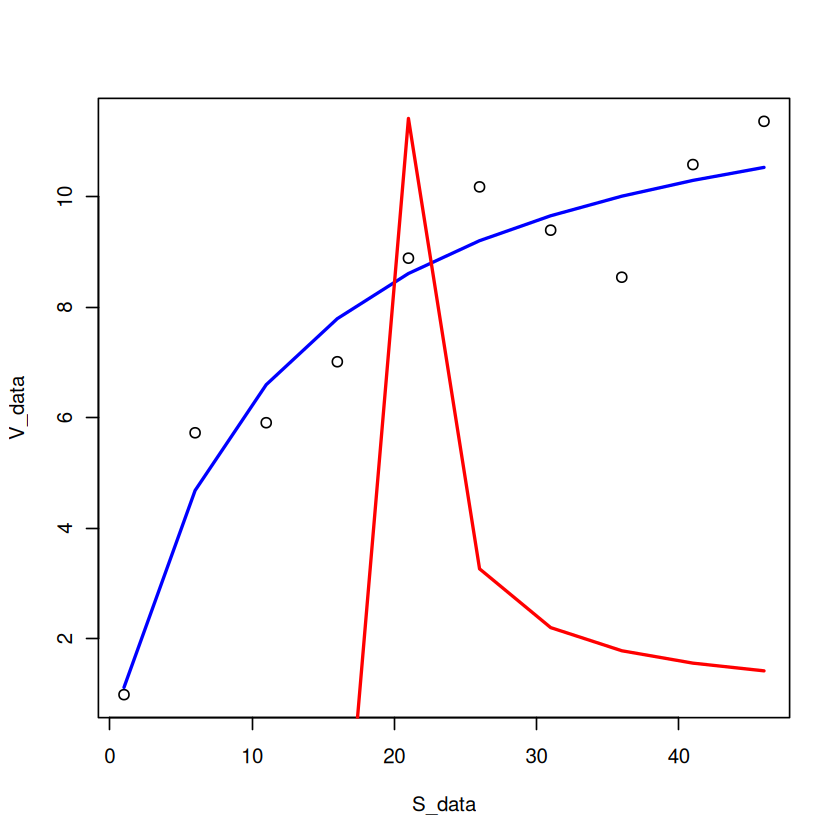

In [18]:
plot(S_data,V_data)  # first plot the data 
lines(S_data,predict(MM_model),lty=1,col="blue",lwd=2) # overlay the original model fit
lines(S_data,predict(MM_model3),lty=1,col="red",lwd=2) # overlay the latest model fit

As you would have guessed from the really funky coefficient estimates that were obtained in `MM_model3`, this is a pretty poor model fit to the data, with the negative value of `K_M` causing the fitted version of the Michaelis-Menten model to behave strangely.

*Also, you could have used the nicer plotting approach that was introduced before.*

Let's try with even more different starting values.  

In [19]:
nls(V_data ~ V_max * S_data / (K_M + S_data), start = list(V_max = 0, K_M = 0.1))

ERROR: Error in nlsModel(formula, mf, start, wts, scaleOffset = scOff, nDcentral = nDcntr): singular gradient matrix at initial parameter estimates


The `singular gradient matrix at initial parameter estimates` error arises from the fact that the starting values you provided were so far from the optimal solution, that the parameter searching in `nls()` failed at the very first step. The algorithm could not figure out where to go from those starting values. In fact, the starting value we gave it is biologically/ physically impossible, because `V_max` can't equal 0.  

Let's look at another pair of starting values that causes the model fitting to fail:  

In [20]:
nls(V_data ~ V_max * S_data / (K_M + S_data), start = list(V_max = -0.1, K_M = 100))

ERROR: Error in nls(V_data ~ V_max * S_data/(K_M + S_data), start = list(V_max = -0.1, : singular gradient


In this case, the model fitting did get started, but eventually failed, again because the starting values were too far from the (approximately) optimal values ($V_{\max} \approx 12.96, K_M \approx 10.61$).

```{note}
There are other types of errors (other than the "singular gadient matrix" one) that the nlls fitting can run into because of poor starting parameter values.
```

And what happens if we start really close to the optimal values? Let's try: 

In [21]:
MM_model4 <- nls(V_data ~ V_max * S_data / (K_M + S_data), start = list(V_max = 12.96, K_M = 10.61))

In [22]:
coef(MM_model)
coef(MM_model4)

V_max      K_M 
12.96369 10.60723

V_max      K_M 
12.96366 10.60715

The results of the first model fit and this last one are still not exactly the same! This drives home the point that nlls is not an "exact" procedure. However, the differences between these two solutions are minuscule, so the main thing to take away is that if the starting values are reasonable, nlls is *exact enough*.       

Note that and even if you started the nlls fitting with the exact parameter values with which you generated the data before introducing errors (so use `start = list(V_max = 12.5, K_M = 7.1)` above instead), you would still get the same result for the coefficients (try it). This is because the nlls fitting will converge back to the parameter estimates based on the actual data, errors and all.

## A more robust nlls algorithm

The standard nlls function in R, `nls`, which we have been using so far, does the nlls fitting by implementing an algorithm called the Gauss-Newton algorithm. While the Gauss-Newton algorithm works well for most simple non-linear models, it has a tendency to "get lost" or "stuck" while searching for optimal parameter estimates (that minimize the residual sum of squares, or rSS). Therefore, `nls` will often fail to fit your model to the data if you start off at starting values for the parameters that are too far from what the optimal values would be, as you saw above (e.g., when you got the `singular gradient matrix` error).    

Some nonlinear models are especially difficult for nls to fit to data because such model have a mathematical form that makes it hard to find parameter combinations that minimize the residual sum of squared (rSS). If this does not makes sense, don't worry about it.

One solution to this is to use a different algorithm than Gauss-Newton. `nls()` has one other algorithm that can be more robust in some situations, called the "port" algorithm. However, there is a better solution still: the Levenberg-Marqualdt algorithm, which is less likely to get stuck (is more robust than) than Gauss-Newton (or port). If you want to learn more about the technicalities of this, [here](https://en.wikipedia.org/wiki/Gauss%E2%80%93Newton_algorithm) are [here](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) are good places to start (also see the readings list at the end of this chapter).


To be able to use nlsLM, we will need to switch to a different nlls function called `nlsLM`. In order to be able to use `nlsLM`, you will need the `nls.lm` r package, which you can install using the method appropriate for your operating system  (e.g., linux users will launch r in `sudo` mode first) and then use:

```r
> install.packages("minpack.lm") 
```

Now load the `minpack.lm` package:

In [23]:
require("minpack.lm")

Loading required package: minpack.lm



Now let's try it (using the same starting values as `MM_model2` above):

In [24]:
MM_model5 <- nlsLM(V_data ~ V_max * S_data / (K_M + S_data), start = list(V_max = 12, K_M = 7))

Now compare the `nls` and `nlsLM` fitted coefficients:

In [25]:
coef(MM_model2)
coef(MM_model5)

V_max      K_M 
12.96363 10.60706

V_max      K_M 
12.96363 10.60706

Close enough. 

Now, let's try fitting the model using all those starting parameter combinations that failed previously:  

In [26]:
MM_model6 <- nlsLM(V_data ~ V_max * S_data / (K_M + S_data), start = list(V_max = .01, K_M = 20))

In [27]:
MM_model7 <- nlsLM(V_data ~ V_max * S_data / (K_M + S_data), start = list(V_max = 0, K_M = 0.1))

In [28]:
MM_model8 <- nlsLM(V_data ~ V_max * S_data / (K_M + S_data), start = list(V_max = -0.1, K_M = 100))

In [29]:
coef(MM_model6)
coef(MM_model7)
coef(MM_model8)

V_max      K_M 
12.96365 10.60711

V_max      K_M 
12.96364 10.60707

V_max      K_M 
12.96364 10.60709

Nice, these all worked with `nlsLM` even though they had failed with `nls`! 

But `nlsLM` also has its limits. Let's try more absurd starting values:

In [30]:
nlsLM(V_data ~ V_max * S_data / (K_M + S_data), start = list(V_max = -10, K_M = -100))

ERROR: Error in nlsModel(formula, mf, start, wts): singular gradient matrix at initial parameter estimates


Here again, nlls fitting fails because these starting values are just too far from the best solution.  

(nlls:Bounding)=
## Bounding parameter values

You can also bound the starting values, i.e., prevent them from exceeding some minimum and maximum value *during* the nlls fitting process.

For example let's first re-run the fitting without bounding the parameters (and some relatively-far-from-optimal starting values):

In [31]:
nlsLM(V_data ~ V_max * S_data / (K_M + S_data), start = list(V_max = 0.1, K_M = 0.1))

Nonlinear regression model
  model: V_data ~ V_max * S_data/(K_M + S_data)
   data: parent.frame()
V_max   K_M 
12.96 10.61 
 residual sum-of-squares: 6.22

Number of iterations to convergence: 12 
Achieved convergence tolerance: 1.49e-08

Now, the same with parameter bounds:

In [32]:
nlsLM(V_data ~ V_max * S_data / (K_M + S_data), start = list(V_max = 0.1, K_M = 0.1), lower=c(0.4,0.4), upper=c(100,100))

Nonlinear regression model
  model: V_data ~ V_max * S_data/(K_M + S_data)
   data: parent.frame()
V_max   K_M 
12.96 10.61 
 residual sum-of-squares: 6.22

Number of iterations to convergence: 10 
Achieved convergence tolerance: 1.49e-08

So when you added bounds, the solution was found in two fewer iterations (not a spectacular improvement, but an improvement nevertheless).

```{note}
The `nls()` function too has an option to provide `lower` and `upper` parameter bounds, but that is only in effect available when using `algorithm = "port"` (only available for a particular algorithm). 
```
However, if you bound the parameters too much (to excessively narrow ranges), the algorithm cannot search sufficient parameter space (combinations of parameters), and will fail to converge on a good solution. For example:   

In [33]:
nlsLM(V_data ~ V_max * S_data / (K_M + S_data), start =  list(V_max = 0.5, K_M = 0.5), lower=c(0.4,0.4), upper=c(20,20))

Nonlinear regression model
  model: V_data ~ V_max * S_data/(K_M + S_data)
   data: parent.frame()
V_max   K_M 
16.09 20.00 
 residual sum-of-squares: 9.227

Number of iterations to convergence: 3 
Achieved convergence tolerance: 1.49e-08

Here the algorithm converged on a poor solution, and in fact took fewer iterations (3) than before to do so. This is because it could not explore sufficient parameter combinations of `V_max` and `K_M` as we have narrowed the range that both these parameters could be allowed to take during the optimization too much.

## Diagnostics of an nlls fit

nlls regression carries the same three key assumptions as Linear models:

* No (in practice, minimal) measurement error in explanatory/independent/predictor variable ($x$-axis variable)

* Data have constant normal variance &mdash; errors in the $y$-axis are homogeneously distributed over the $x$-axis range

* The measurement/observation errors are Normally distributed (Gaussian)

At the very least, it is a good idea to plot the residuals of a fitted nlls model. Let's do that for our Michaelis-Menten Model fit:

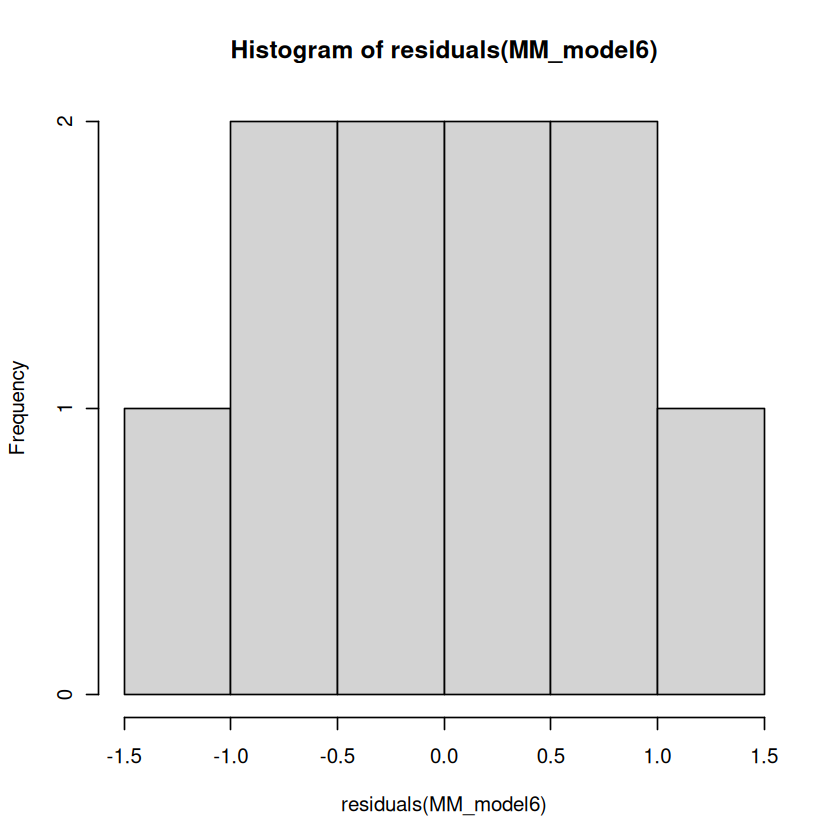

In [34]:
hist(residuals(MM_model6))

The residuals look OK. But this should not come as a surprise because we generated these "data" ourselves using normally-distributed errors!

You may also want to look at further diagnostics, as we did [previously](regress:Diagnostics) in the case of Linear models. The most convenient way to do this is to use the `nlstools` package. We will not go into it here, but you can have a look at its [documentation](https://rdrr.io/rforge/nlstools/). Note that you will need to install this package as it is not one of the core (base) r packages. `nlstools` has some other handy utilities as well; for example, its `preview` command allows you to visualise how good the starting values are (by evaluating your non-linear function at those values) in advance of the actual fitting.    

```{note}
For the remaining examples, we will switch to using `nlsLM` instead of `nls`.
```

## Allometric scaling of traits

Now let's move on to a very common class of traits in biology: physical traits like body weight, wing span, body length, limb length, eye size, ear width, etc. 

We will look at a very common phenomenon called [allometric scaling](https://en.wikipedia.org/wiki/Allometry). Allometric relationships between linear measurements such as body length, limb length, wing span, and thorax width are a good way to obtain estimates of body weights of individual organisms. We will look at allometric scaling of body weight vs. total body length in dragonflies and damselfiles. 

Allometric relationships take the form:

$$
y = a x^b
$$(eq:allom)

where $x$ and $y$ are morphological measures (body length and body weight respectively, in our current example), the constant is the value of $y$ at body length $x = 1$ unit, and $b$ is the scaling "exponent". This is also called a power-law, because $y$ relates to $x$ through a simple power. 

Let's fit a power low to a typical allometric relationship: The change in body weight vs change in body length. In general, this relationship is a allometry; that is, body weight does not increase proportionally with some measure of body length.    

First, let's look at the data. You can get the data [here](https://raw.githubusercontent.com/mhasoba/TheMulQuaBio/master/content/data/genome_size.csv) (first click on link and use "Save as" or `Ctrl+S` to download it as a csv). 

$\star$ Save the `genome_size.csv` data file to your `data` directory, and import it into your r workspace:

In [35]:
MyData <- read.csv("../data/genome_size.csv") # using relative path assuming that your working directory is "code"

head(MyData)

,Suborder,Family,Species,GenomeSize,GenomeSE,GenomeN,BodyWeight,TotalLength,HeadLength,ThoraxLength,AdbdomenLength,ForewingLength,HindwingLength,ForewingArea,HindwingArea,MorphologyN
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,Anisoptera,Aeshnidae,Aeshna canadensis,2.20,NA,1,0.159,67.58,6.83,11.81,48.94,45.47,45.40,369.57,483.61,2
2,Anisoptera,Aeshnidae,Aeshna constricta,1.76,0.06,4,0.228,71.97,6.84,10.72,54.41,46.00,45.48,411.15,517.38,3
3,Anisoptera,Aeshnidae,Aeshna eremita,1.85,NA,1,0.312,78.80,6.27,16.19,56.33,51.24,49.47,460.72,574.33,1
4,Anisoptera,Aeshnidae,Aeshna tuberculifera,1.78,0.10,2,0.218,72.44,6.62,12.53,53.29,49.84,48.82,468.74,591.42,2
5,Anisoptera,Aeshnidae,Aeshna umbrosa,2.00,NA,1,0.207,73.05,4.92,11.11,57.03,46.51,45.97,382.48,481.44,1
6,Anisoptera,Aeshnidae,Aeshna verticalis,1.59,NA,1,0.220,66.25,6.48,11.64,48.13,45.91,44.91,400.40,486.97,1


[Anisoptera](https://en.wikipedia.org/wiki/Dragonfly) are dragonflies, and [Zygoptera](https://en.wikipedia.org/wiki/Damselfly) are Damselflies. The variables of interest are `BodyWeight` and `TotalLength`. Let's use the dragonflies data subset. 

So subset the data accordingly and remove NAs:

In [36]:
Data2Fit <- subset(MyData,Suborder == "Anisoptera")

Data2Fit <- Data2Fit[!is.na(Data2Fit$TotalLength),] # remove NA's

Plot the data:

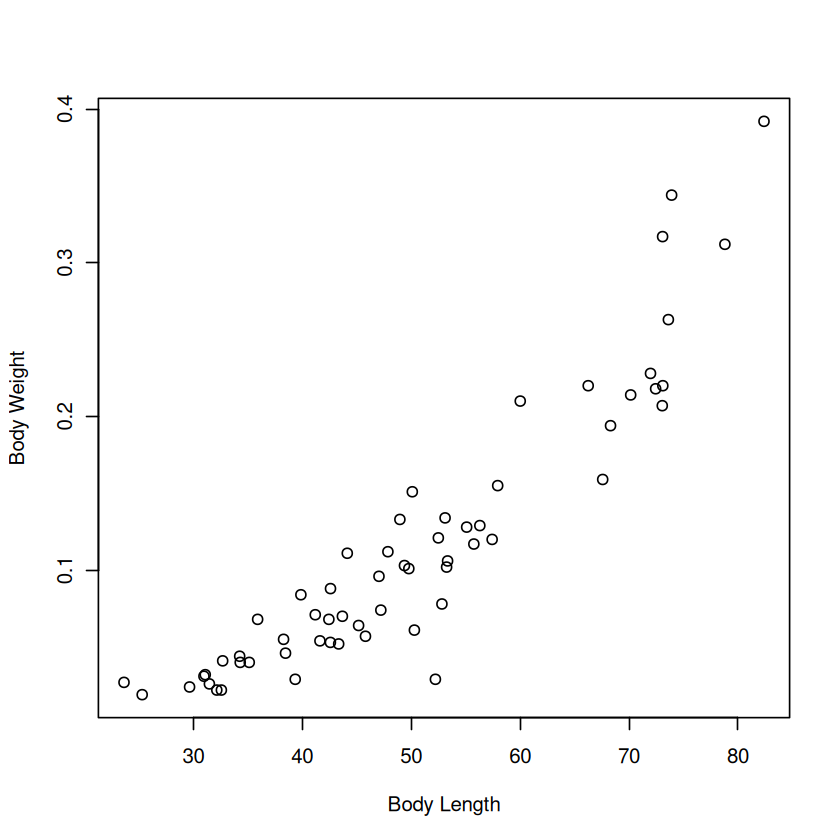

In [37]:
plot(Data2Fit$TotalLength, Data2Fit$BodyWeight, xlab = "Body Length", ylab = "Body Weight")

Or, using `ggplot`:

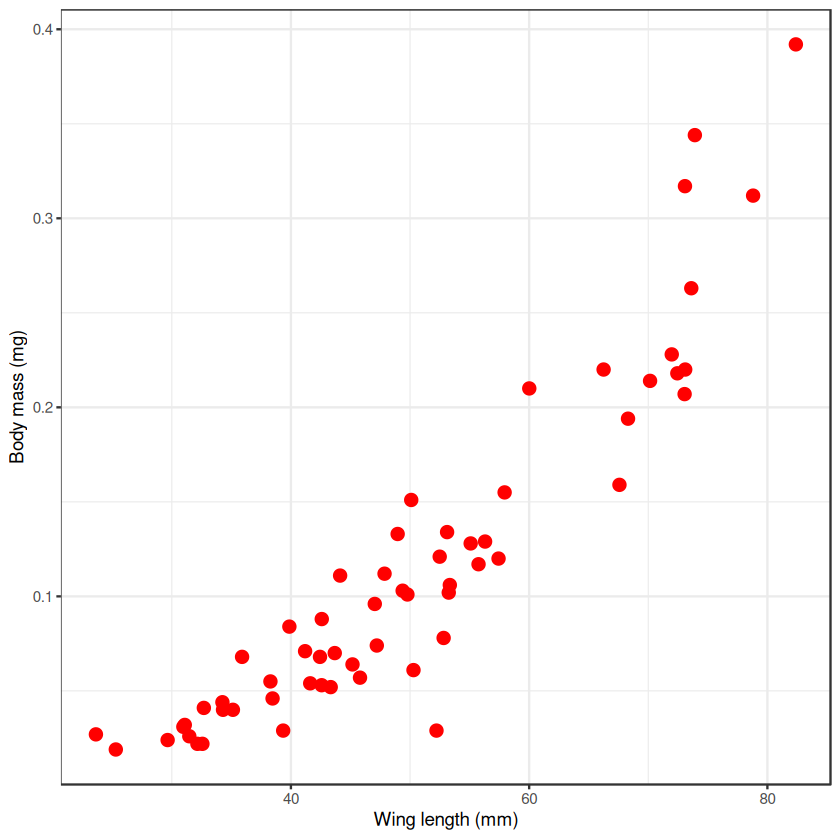

In [38]:
library("ggplot2")

ggplot(Data2Fit, aes(x = TotalLength, y = BodyWeight)) + 
geom_point(size = (3),color="red") + theme_bw() + 
labs(y="Body mass (mg)", x = "Wing length (mm)")

You can see these body weights of dragonflies does not increase proportionally with body length &ndash; they curve upwards w.R.t. wing length (so the allometric constant $b$ in eqn {eq}`eq:allom` mustbe greater than 1), instead of increasing as a straight line (in which case $b = 1$ (isometry, instead of allometry). 

Now fit the model to the data using nlls:

In [39]:
nrow(Data2Fit)

[1] 60

In [40]:
PowFit <- nlsLM(BodyWeight ~ a * TotalLength^b, data = Data2Fit, start = list(a = .1, b = .1))

### nlls fitting using a model object 

Another way to tell `nlsLM` which model to fit, is to first create a function object for the power law model:

In [41]:
powMod <- function(x, a, b) {
 return(a * x^b)
}

Now fit the model to the data using nlls by calling the model:

In [42]:
PowFit <- nlsLM(BodyWeight ~ powMod(TotalLength,a,b), data = Data2Fit, start = list(a = .1, b = .1))

Which gives the same result as before (you can check it).

### Visualizing the fit

The first thing to do is to see how well the model fitted the data, for which plotting is the best first option. So let's visualize the fit. For this, first we need to generate a vector of body lengths (the x-axis variable) for plotting: 

In [43]:
Lengths <- seq(min(Data2Fit$TotalLength),max(Data2Fit$TotalLength),len=200)

In [44]:
coef(PowFit)["a"]
coef(PowFit)["b"]

a 
3.940685e-06

b 
2.585048

In [45]:
Predic2PlotPow <- powMod(Lengths,coef(PowFit)["a"],coef(PowFit)["b"])

Next, calculate the predicted line. For this, we will need to extract the coefficient from the model fit object using the `coef()`command. 

Now plot the data and the fitted model line:

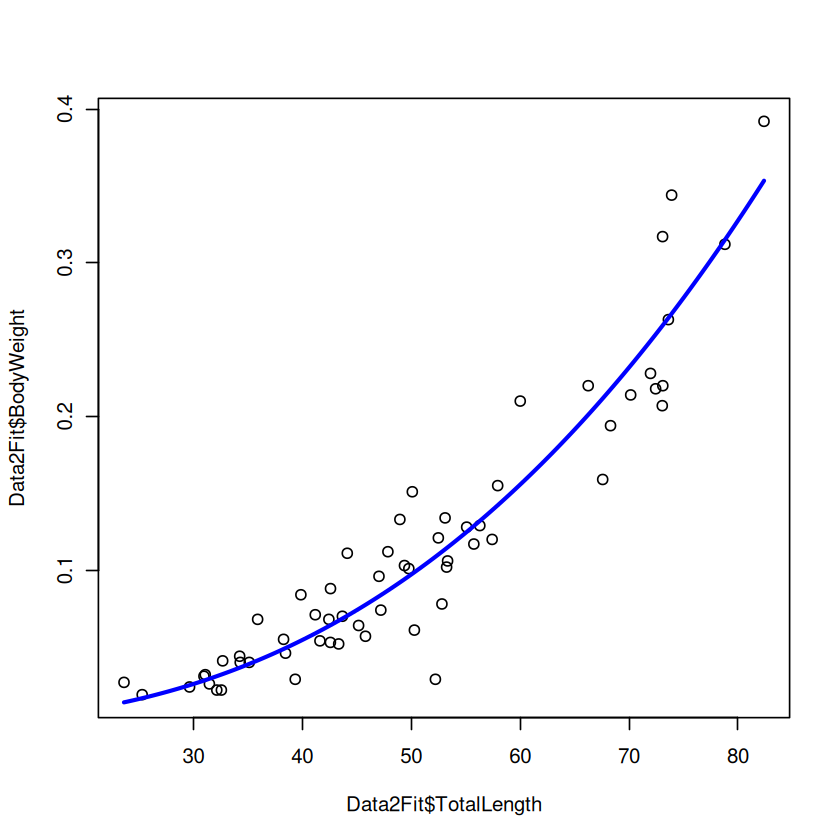

In [46]:
plot(Data2Fit$TotalLength, Data2Fit$BodyWeight)
lines(Lengths, Predic2PlotPow, col = 'blue', lwd = 2.5)

### Summary of the fit

Now lets get some stats of this nlls fit. Having obtained the fit object (`PowMod`), we can use `summary()` just like we would for a `lm()` fit object: 

In [47]:
summary(PowFit)


Formula: BodyWeight ~ powMod(TotalLength, a, b)

Parameters:
   Estimate Std. Error t value Pr(>|t|)    
a 3.941e-06  2.234e-06   1.764    0.083 .  
b 2.585e+00  1.348e-01  19.174   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.02807 on 58 degrees of freedom

Number of iterations to convergence: 39 
Achieved convergence tolerance: 1.49e-08


In [48]:
print(confint(PowFit))

Waiting for profiling to be done...



          2.5%        97.5%
a 1.171935e-06 1.205273e-05
b 2.318292e+00 2.872287e+00


### Examine the residuals 


As we did before, let's plot the residuals around the fitted model:

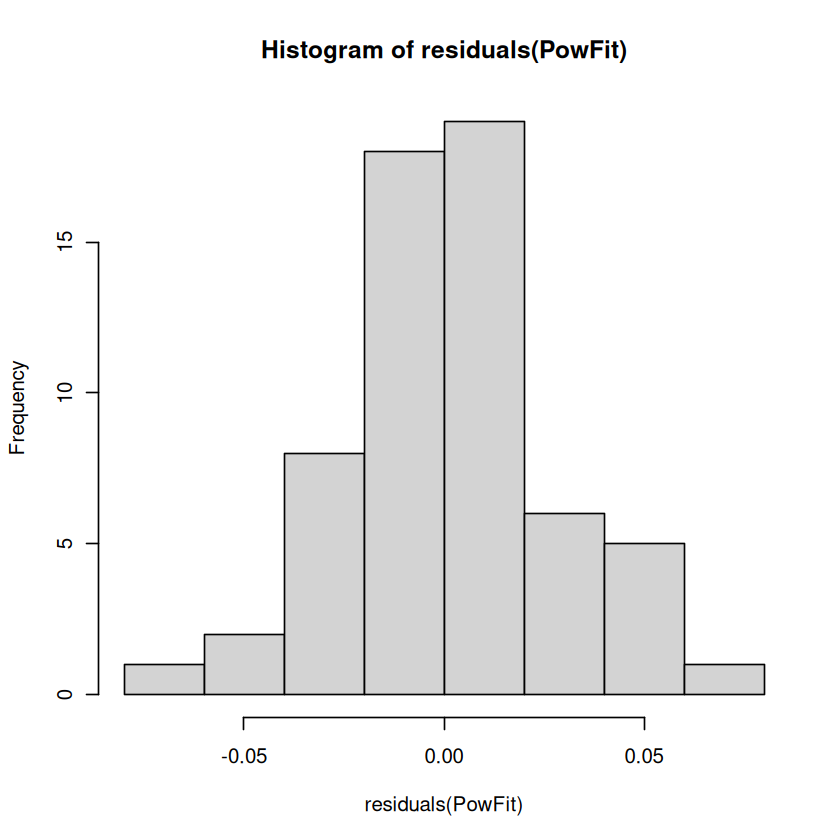

In [49]:
hist(residuals(PowFit))

The residuals look OK.

```{tip}
remember, when you write this analysis into a stand-alone r script, you should put all commands for loading packages (`library()`, `require()`) at the start of the script. *  
```

##### Exercises <a id='Allom_Exercises'></a>

(a) Make the same plot as above, fitted line and all, in `ggplot`, and add (display) the equation you estimated to your new (ggplot) plot. The equation is: $\text{Weight} = 3.94 \times 10^{-06} \times \text{Length}^{2.59}$

(b) Try playing with the starting values, and see if you can "break" the model fitting -- that is, change the starting values till the nlls fitting does not converge on a solution.

(c) repeat the model fitting (including a-b above) using the Zygoptera data subset.

 
(d) There is an alternative (and in fact, more commonly-used) approach for fitting the allometric model to data: using Ordinary Least Squares on bi-logarithamically transformed data. That is, if you take a log of both sides of the [allometric equation](#eq:allom) we get,

$$
\log(y) = \log(a) + b \log(x)
$$

This is a straight line equation of the form $c = d + b z $, where $c = \log(c)$, $d = \log(a)$, $z = \log(x)$, and $b$ is now the slope parameter. So you can use Ordinary Least Squares and the linear models framework (with `lm()`) in R to estimate the parameters of the allometric equation. 

In this exercise, try comparing the nlls vs OLS methods to see how much difference you get in the parameter estimates between them. For example, see the methods used in this paper by [Cohen et al 2012](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3465447/).

(e) The allometry between Body weight and Length is not the end of the story. You have a number of other linear morphological measurements (`HeadLength`, `ThoraxLength`, `AdbdomenLength`, `ForewingLength`, `HindwingLength`, `ForewingArea`, and `HindwingArea`) that can also be investigated. In this exercise, try two lines of investigation (again, repeated separately for Dragonflies and Damselfiles): 

 (i) How do each of these measures allometrically scale with Body length (obtain estimates of scaling constant and exponent)? (Hint: you may want to use the `pairs()` command in R to get an overview of all the pairs of potential scaling relationships. 

 (ii) Do any of the linear morphological measurements other than body length better predict Body weight? That is, does body weight scale more tightly with a linear morphological measurement other than total body length? You would use model selection here, which we will learn next. But for now, you can just look at and compare the $r^2$ values of the models.

(Model-Fitting-r-Comparing-Models)=
## Comparing models

 *How do we know that there isn't a better or alternative model that adequately explains the pattern in your dataset?* 

This is important consideration in all data analyses (and more generally, the scientific method!), so you must aim to compare your nlls model with an one or more alternatives for a more extensive and reliable investigation of the problem. 

Let's use model comparison to investigate whether the relationship between body weight and length we found above is indeed allometric. For this, we need an alternative model that can be fitted to the same data. Let's try a quadratic curve, which is of the form:

$$
y = a + b x + c x^2
$$

This can also capture curvature in data, and is an alternative model to the [allometric equation](#eq:allom). Note that this mode is linear in its parameters (a linear model), which you can fit to the simply data using your familiar `lm()` function: 

In [50]:
QuaFit <- lm(BodyWeight ~ poly(TotalLength,2), data = Data2Fit)

And like before, we obtain the predicted values (but this time using the `predict.lm` function):

In [51]:
Predic2PlotQua <- predict.lm(QuaFit, data.frame(TotalLength = Lengths))

Now let's plot the two fitted models together:

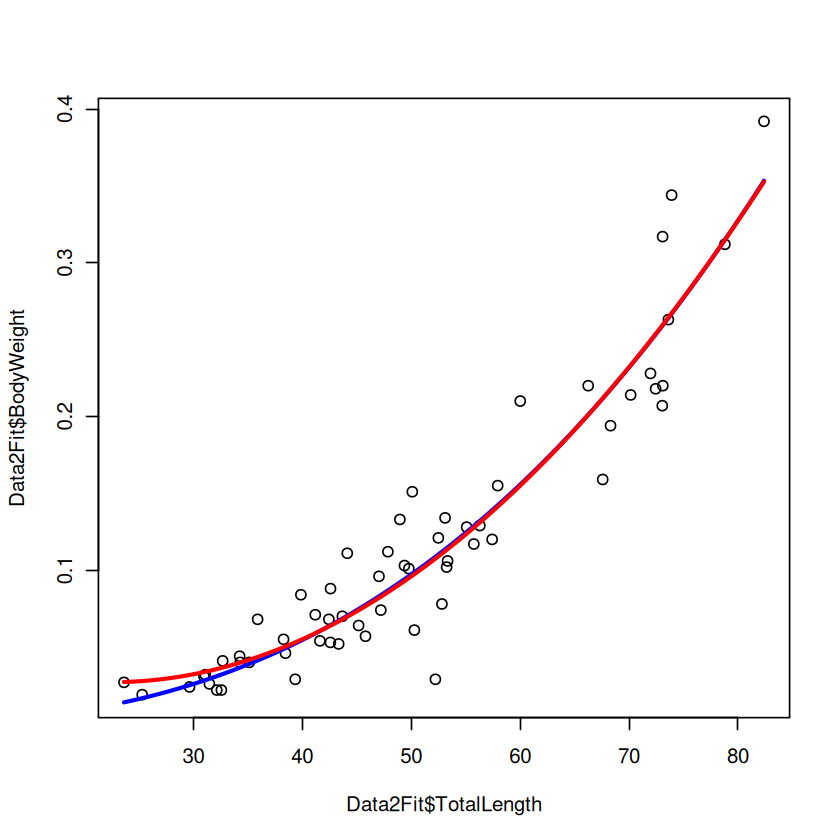

In [52]:
plot(Data2Fit$TotalLength, Data2Fit$BodyWeight)
lines(Lengths, Predic2PlotPow, col = 'blue', lwd = 2.5)
lines(Lengths, Predic2PlotQua, col = 'red', lwd = 2.5)

Very similar fits, except that the quadratic model seems to deviate a bit from the data at the lower end of the data range. Let's do a proper, formal model comparison now to check which model better-fits the data.

First calculate the R$^2$ values of the two fitted models:

In [53]:
rSS_Pow <- sum(residuals(PowFit)^2) # residual sum of squares
TSS_Pow <- sum((Data2Fit$BodyWeight - mean(Data2Fit$BodyWeight))^2) # Total sum of squares
rSq_Pow <- 1 - (rSS_Pow/TSS_Pow) # r-squared value

rSS_Qua <- sum(residuals(QuaFit)^2) # residual sum of squares
TSS_Qua <- sum((Data2Fit$BodyWeight - mean(Data2Fit$BodyWeight))^2) # Total sum of squares
rSq_Qua <- 1 - (rSS_Qua/TSS_Qua) # r-squared value

rSq_Pow 
rSq_Qua

[1] 0.9005475

[1] 0.9003029

Not very useful. In general, r$^2$ is a good measure of model fit, but cannot be used for model selection &ndash; especially not here, given the tiny difference in R$^2$'s.

Instead, as explained in the [lecture](https://github.com/mhasoba/TheMulQuaBio/blob/master/lectures/ModelFitting), we can use the Akaike Information Criterion (AIC):

In [54]:
n <- nrow(Data2Fit) #set sample size
pPow <- length(coef(PowFit)) # get number of parameters in power law model
pQua <- length(coef(QuaFit)) # get number of parameters in quadratic model

AIC_Pow <- n + 2 + n * log((2 * pi) / n) + n * log(rSS_Pow) + 2 * pPow
AIC_Qua <- n + 2 + n * log((2 * pi) / n) + n * log(rSS_Qua) + 2 * pQua
AIC_Pow - AIC_Qua

[1] -2.147426

Of course, as you might have suspected, we can do this using an in-built function in R! 

In [55]:
AIC(PowFit) - AIC(QuaFit)

[1] -2.147426

 * So which model wins? * As we had dicussed in the nlls lecture, a rule of thumb is that a AIC value difference (typically denoted as $\Delta$AIC) >-2 (more negative is better) is a acceptable cutoff for calling a winner. So the power law (allometric model) is a better fit here. read the [Johnson & Omland paper](https://github.com/mhasoba/TheMulQuaBio/blob/master/readings/Modelling/JohnsonOmland2004.pdf) for more on model selection in Ecology and Evolution. 

### Exercises <a id='ModelSelection_Exercises'></a>

(a) Calculate the bayesian Information Criterion (BIC), also know as the Schwarz Criterion (see your Lecture notes and the [Johnson & Omland paper](https://github.com/mhasoba/TheMulQuaBio/blob/master/readings/Modelling/JohnsonOmland2004.pdf), and use $\Delta$BIC to select the better fitting model. 

(b) Fit a straight line to the same data and compare with the allometric and quadratic models.

(c) repeat the model comparison (incuding 1-2 above) using the Damselflies (Zygoptera) data subset -- does the allometric model still win?

(d) repeat exercise (e)(i) and (ii) from the [above set](#Allom_Exercises), but with model comparison (e.g., again using a quadratic as an alternative model) to establish that the relationships are indeed allometric.

(e) repeat exercise (e)(ii) from the [above set](#Allom_Exercises), but with model comparison to establish which linear measurement is the best predictor of Body weight.

## Albatross chick growth

Now let's look at a different trait example: the growth of an individual albatross chick (you can find similar data for vector and non-vector arthropods in [VecTraits](https://vectorbyte.org/)). First load and plot the data:

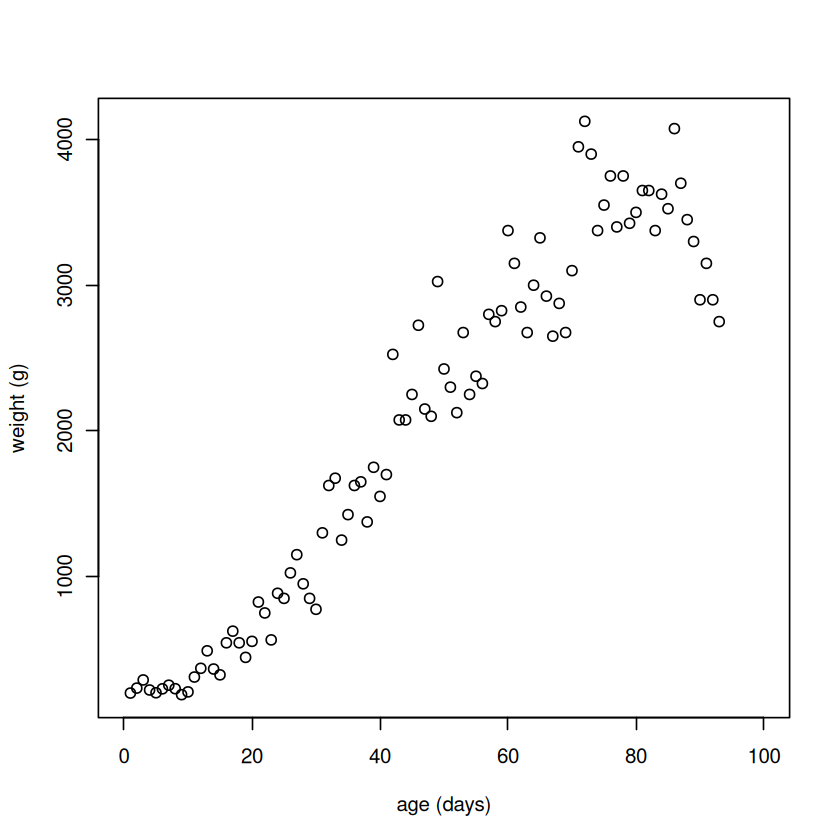

In [56]:
alb <- read.csv(file="../data/albatross_grow.csv")
alb <- subset(x=alb, !is.na(alb$wt))
plot(alb$age, alb$wt, xlab="age (days)", ylab="weight (g)", xlim=c(0, 100))

##### Fitting the three models using nlls

Let's fit multiple models to this dataset.

The Von Bertalanffy model is commonly used for modelling the growth of an individual. It's formulation is:

$$
W(t) = \rho (L_{\infty}(1-e^{-Kt})+L_0 e^{-Kt})^3
$$

If we pull out $L_{\infty}$ and define $c=L_0/L_{\infty}$ and $W_{\infty}=\rho L_{\infty}^3$ this equation becomes:

$$
W(t) = W_{\infty}(1-e^{-Kt}+ c e^{-Kt})^3.
$$

$W_{\infty}$ is interpreted as the mean asymptotic weight, and $c$ the ratio between the initial and final lengths. This second equation is the one we will fit.

We will compare this model against the classical Logistic growth equation and a straight line.

The logistic equation is:

$$
N_t = \frac{N_0 K e^{r t}}{K + N_0 (e^{r t} - 1)}
$$

Here $N_t$ is population size at time $t$, $N_0$ is initial population size, $r$ is maximum growth rate (AKA $r_\text{max}$), and $K$ is carrying capacity.


 First, as we did before, let's define the R functions for the two models:

In [57]:
logistic1 <- function(t, r, K, N0){
 N0 * K * exp(r * t)/(K+N0 * (exp(r * t)-1))
}

vonbert.w <- function(t, Winf, c, K){
 Winf * (1 - exp(-K * t) + c * exp(-K * t))^3
}

For the straight line, we use simply use R's `lm()` function, as that is a linear least squares problem. Using nlls will give (approximately) the same answer, of course. Now fit all 3 models using least squares. 

We will scale the data before fitting to improve the stability of the estimates:

In [58]:
scale <- 4000

alb.lin <- lm(wt/scale ~ age, data = alb)

In [59]:
alb.log <- nlsLM(wt/scale~logistic1(age, r, K, N0), start=list(K=1, r=0.1, N0=0.1), data=alb)

alb.vb <- nlsLM(wt/scale~vonbert.w(age, Winf, c, K), start=list(Winf=0.75, c=0.01, K=0.01), data=alb)

Next let's calculate predictions for each of the models across a range of ages.

In [60]:
ages <- seq(0, 100, length=1000)

pred.lin <- predict(alb.lin, newdata = list(age=ages)) * scale

pred.log <- predict(alb.log, newdata = list(age=ages)) * scale

pred.vb <- predict(alb.vb, newdata = list(age=ages)) * scale

And finally plot the data with the fits:

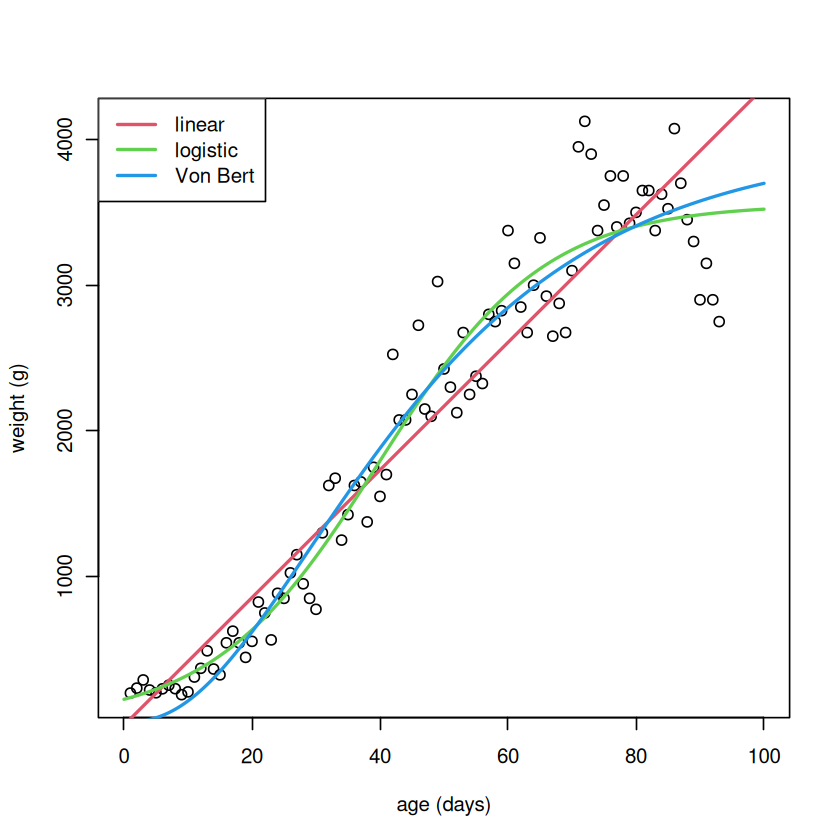

In [61]:
plot(alb$age, alb$wt, xlab="age (days)", ylab="weight (g)", xlim=c(0,100))
lines(ages, pred.lin, col=2, lwd=2)
lines(ages, pred.log, col=3, lwd=2)
lines(ages, pred.vb, col=4, lwd=2)

legend("topleft", legend = c("linear", "logistic", "Von Bert"), lwd=2, lty=1, col=2:4)

Next examine the residuals between the 3 models:

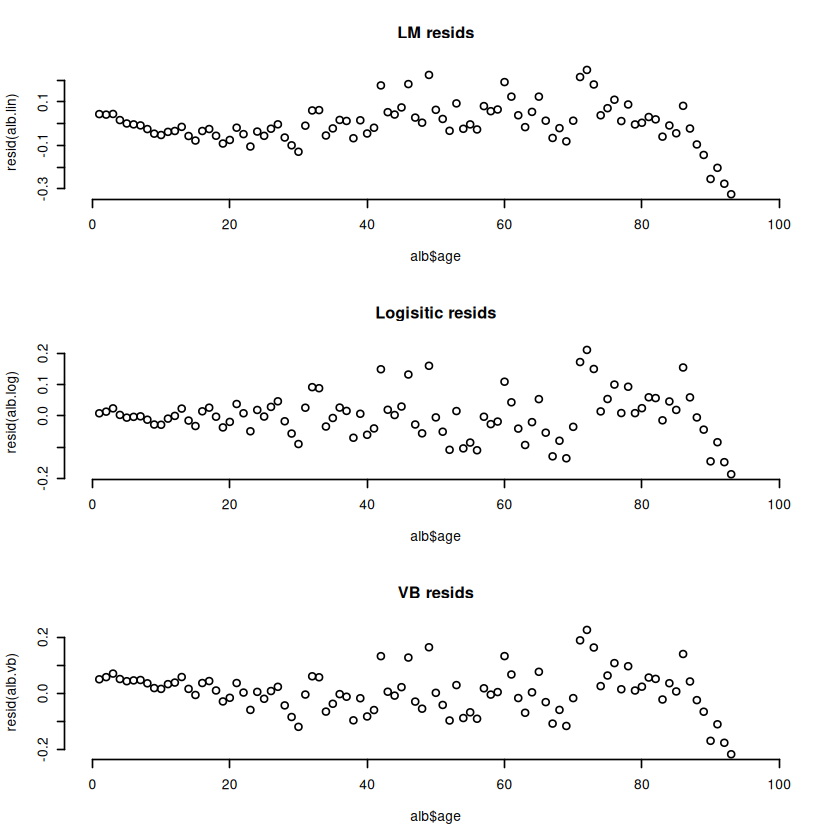

In [62]:
par(mfrow=c(3,1), bty="n")
plot(alb$age, resid(alb.lin), main="LM resids", xlim=c(0,100))
plot(alb$age, resid(alb.log), main="Logisitic resids", xlim=c(0,100))
plot(alb$age, resid(alb.vb), main="VB resids", xlim=c(0,100))

The residuals for all 3 models still exhibit some patterns. In particular, the data seems to go down near the end of the observation period, but none of these models can capture that behavior. 

Finally, let's compare the 3 models using a simpler approach than the AIC/BIC one that we used [above](#Allom_Exercises) by calculating adjusted Sums of Squared Errors (SSE's):

In [63]:
n <- length(alb$wt)
list(lin=signif(sum(resid(alb.lin)^2)/(n-2 * 2), 3), 
 log= signif(sum(resid(alb.log)^2)/(n-2 * 3), 3), 
 vb= signif(sum(resid(alb.vb)^2)/(n-2 * 3), 3))   

$lin
[1] 0.00958

$log
[1] 0.0056

$vb
[1] 0.00628

The adjusted SSE accounts for sample size and number of parameters by dividing the rSS by the residual degrees of freedom. Adjusted SSE can also be used for model selection like AIC/BIC (but is less robust than AIC/BIC). The residual degrees of freedom is calculated as the number of response values (sample size, $n$) minus 2, times the number of fitted coefficients $m$ (= 2 or 3 in this case) estimated.

The logistic model has the lowest adjusted SSE, so it's the best by this measure. It is also, visually, a better fit. 

### Exercises <a id='Albatross_Exercises'></a>

(a) Use AIC/BIC to perform model selection on the Albatross data as we did for the trait allometry example.

(b) Write this example as a self-sufficient r script, with ggplot istead of base plotting 

## Aedes aegypti fecundity

Now let's look at a disease vector example. These data measure the reponse of * Aedes aegypti * fecundity to temperature. 

First load and visualize the data:

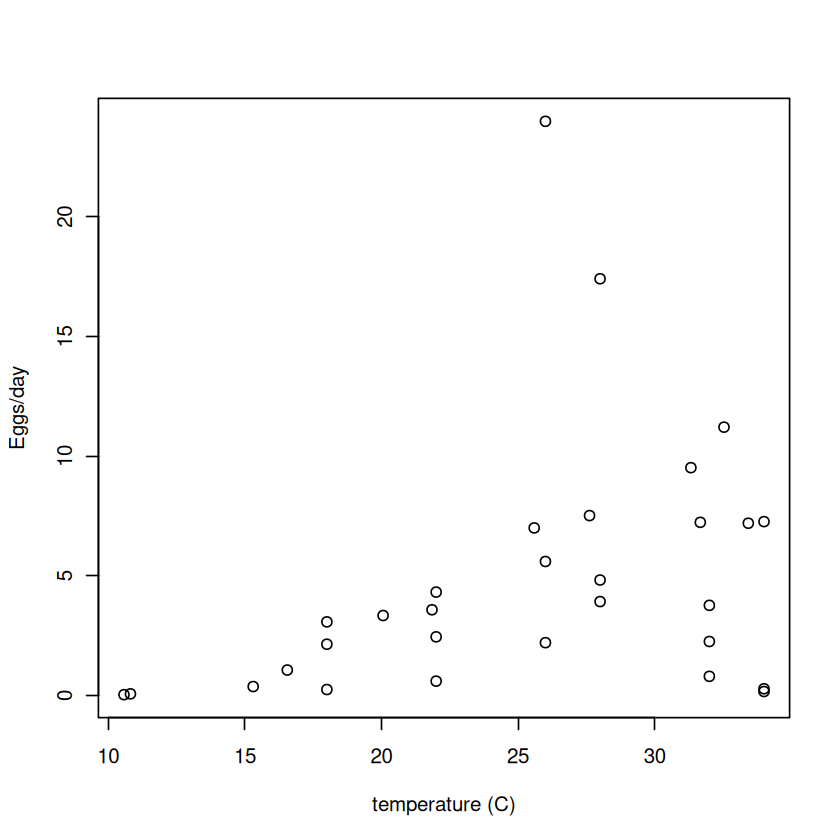

In [64]:
aedes <- read.csv(file="../data/aedes_fecund.csv")

plot(aedes$T, aedes$EFD, xlab="temperature (C)", ylab="Eggs/day")

(Model-Fitting-nlls-TPCs)=
### The Thermal Performance Curve models

Let's define some models for Thermal Performance Curves:

In [65]:
quad1 <- function(T, T0, Tm, c){
 c * (T-T0) * (T-Tm) * as.numeric(T<Tm) * as.numeric(T>T0)
}

Instead of using the inbuilt quadratic function in R, we we defined our own to make it easier to choose starting values, and so that we can force the function to be equal to zero above and below the minimum and maximum temperature thresholds (more on this below).

In [66]:
briere <- function(T, T0, Tm, c){
 c * T * (T-T0) * (abs(Tm-T)^(1/2)) * as.numeric(T<Tm) * as.numeric(T>T0)
}

The Briere function is a commonly used model for temperature dependence of insect traits. See here [section](Miniproj-TPCs-Models) for more info. Unlike the original [model definition](Miniproj-TPCs-Models), we have used `abs()` to allow the nlls algorithm to explore the full parameter space of $T_m$; if we did not do this, the nlls could fail as soon as a value of $T_m < T$ was reached during the optimization, because the [square root of a negative number is complex](https://en.wikipedia.org/wiki/Square_root). Another way to deal with this issue is to set parameter bounds on $T_m$ so that it is can never be less than T. However, this is a more technical approach that we will not go into here.   
 
As in the case of the albatross growth data, we will also compare the above two models with a * straight line * (again, its a linear model, so we can just use `lm()` without needing to define a function for it). 

Now fit all 3 models using least squares. Although it's not as necessary here (as the data don't have as large values as the albatross example), lets again scale the data first: 

In [67]:
scale <- 20

aed.lin <- lm(EFD/scale ~ T, data=aedes)

aed.quad <- nlsLM(EFD/scale~quad1(T, T0, Tm, c), start=list(T0=10, Tm=40, c=0.01), data=aedes)

aed.br <- nlsLM(EFD/scale~briere(T, T0, Tm, c), start=list(T0=10, Tm=40, c=0.1), data=aedes)

### Exercises <a id='Aedes_Exercises'></a>

(a) Complete the * Aedes * data analysis by fitting the models, calculating predictions and then comparing models. Write a single, self-standing script for it. Which model fits best? By what measure?

(b) In this script, use ggplot instead of base plotting.

## Abundance data as an example

Fluctuations in the abundance (density) of single populations may play a crucial role in ecosystem dynamics and emergent functional characteristics, such as rates of carbon fixation or disease transmission. For example, if vector population densities or their traits change at the same or shorter timescales than the rate of disease transmission, then (vector) abundance fluctuations can cause significant fluctuations in disease transmission rates. Indeed, most disease vectors are small ectotherms with short generation times and greater sensitivity to environmental conditions than their (invariably larger, longer-lived, and often, endothermic) hosts. So understanding how populations vary over time, space, and with respect to environmental variables such as temperature and precipitation is key. We will look at fitting models to the growth of a single population here. 

(Model-Fitting-r-Population-Growth)=

## Population growth rates

A population grows exponentially while its abundance is low and resources are not limiting (the Malthusian principle). This growth then slows and eventually stops as resources become limiting. There may also be a time lag before the population growth really takes off at the start. We will focus on microbial (specifically, bacterial) growth rates. Bacterial growth in batch culture follows a distinct set of phases; lag phase, exponential phase and stationary phase. During the lag phase a suite of transcriptional machinery is activated, including genes involved in nutrient uptake and metabolic changes, as bacteria prepare for growth. During the exponential growth phase, bacteria divide at a constant rate, the population doubling with each generation. When the carrying capacity of the media is reached, growth slows and the number of cells in the culture stabilizes, beginning the stationary phase. 

Traditionally, microbial growth rates were measured by plotting cell numbers or culture density against time on a semi-log graph and fitting a straight line through the exponential growth phase &ndash; the slope of the line gives the maximum growth rate ($r_{max}$). Models have since been developed which we can use to describe the whole sigmoidal bacterial growth curve (e.g., using nlls). Here we will take a look at these different approaches, from applying linear models to the exponential phase, through to fitting non-linear models to the full growth curve.

Let's first generate some "data" on the number of bacterial cells as a function of time that we can play with:

In [68]:
t <- seq(0, 22, 2)
N <- c(32500, 33000, 38000, 105000, 445000, 1430000, 3020000, 4720000, 5670000, 5870000, 5930000, 5940000)

set.seed(1234) # To ensure we always get the same random sequence in this example "dataset" 

data <- data.frame(t, N * (1 + rnorm(length(t), sd = 0.1))) # add some random error

names(data) <- c("Time", "N")

head(data)

,Time,N
,<dbl>,<dbl>
1,0,28577.04
2,2,33915.52
3,4,42120.88
4,6,80370.17
5,8,464096.05
6,10,1502365.99


Note how we added some random "sampling" error using `N * (1 + rnorm(length(t), sd = .1))`. 

This means that we are adding an error at each time point $t$ (let's call this fluctuation $\epsilon_t$) as a *percentage* of the population ($N_t$) at that time point in a vectorized way. That is, we are performing the operation $N_t \times (1 + \epsilon_t)$ at all time points at one go. This is important to note because this is often the way that errors appear &ndash; proportional to the value being measured.

Now let's plot these data:

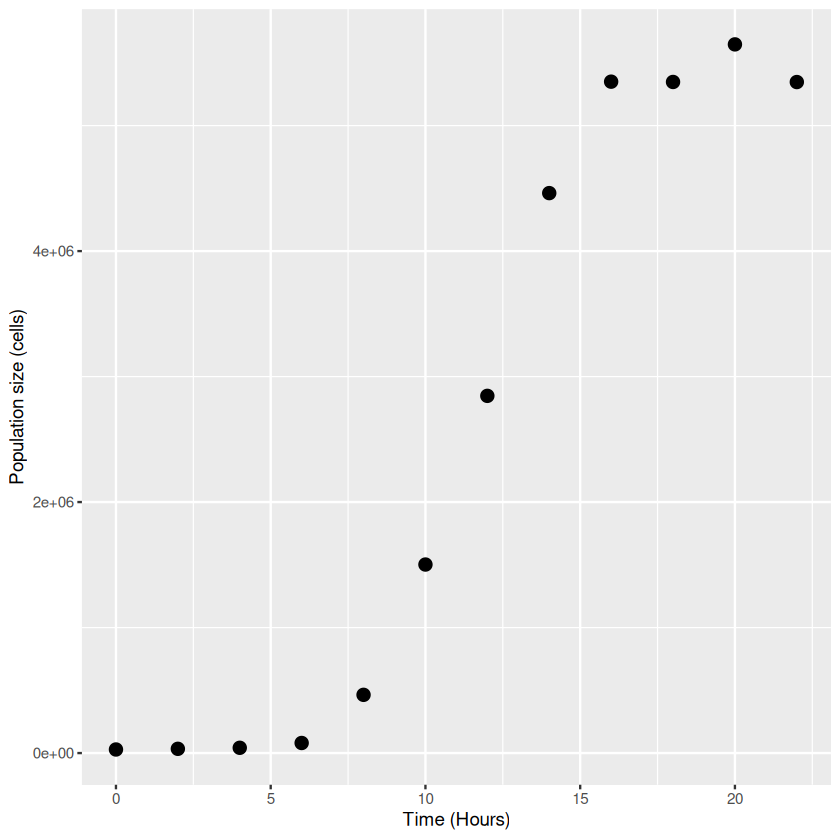

In [69]:
ggplot(data, aes(x = Time, y = N)) + 
 geom_point(size = 3) +
 labs(x = "Time (Hours)", y = "Population size (cells)")

#### Basic approach

The size of an exponentially growing population ($N$) at any given time ($t$) is given by:

$
N(t) = N_0 e^{rt} ,
$

where $N_0$ is the initial population size and $r$ is the growth rate. We can re-arrange this to give:

$
r = \frac{\log(N(t)) - \log(N_0)}{t} ,
$

That is, in exponential growth at a constant rate, the growth rate can be simply calculated as the difference in the log of two population sizes, over time. We will log-transform the data and estimate by eye where growth looks exponential.

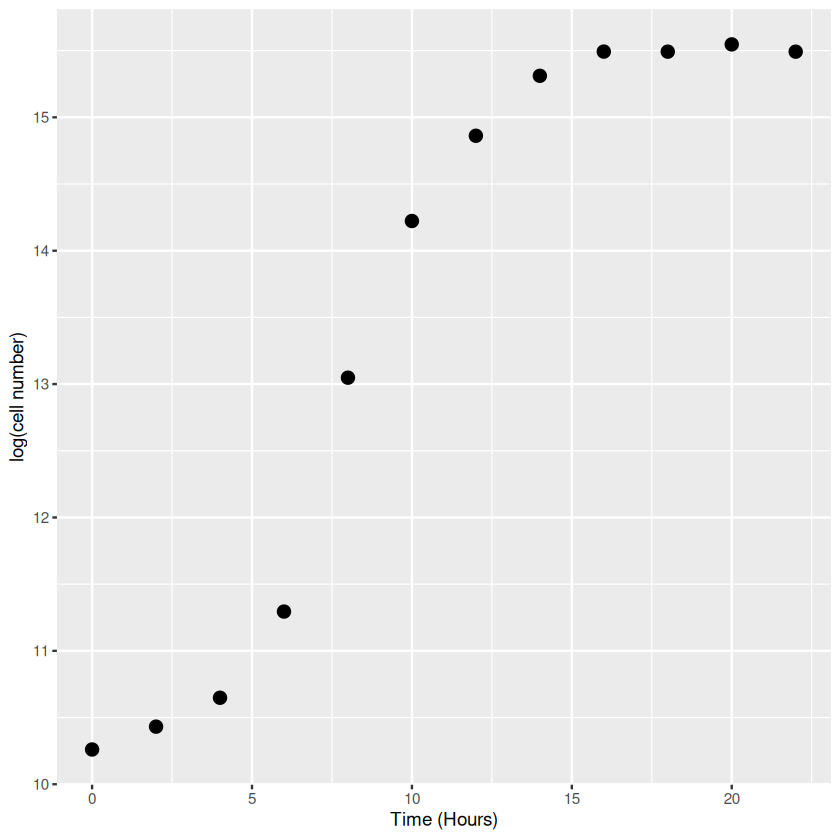

In [70]:
data$LogN <- log(data$N)

# visualise
ggplot(data, aes(x = t, y = LogN)) + 
 geom_point(size = 3) +
 labs(x = "Time (Hours)", y = "log(cell number)")

By eye the logged data looks fairly linear (beyond the initial "lag phase" of growth; see below) between hours 5 and 10, so we'll use that time-period to calculate the growth rate. 

In [71]:
(data[data$Time == 10,]$LogN - data[data$Time == 6,]$LogN)/(10-6)

[1] 0.7320383

This is our first, most basic estimate of $r$.

Or, we can decide not to eyeball the data, but just pick the maximum observed gradient of the curve. For this, we can use the the `diff()` function:

In [72]:
diff(data$LogN)

[1]  0.171269154  0.216670872  0.646099643  1.753448393  1.174704941
 [6]  0.639023868  0.449529740  0.181493482 -0.000450184  0.054490710
[11] -0.054600924

This gives all the (log) population size differences between successive timepoint pairs. The max of this is what we want, divided by the time-step.

In [73]:
max(diff(data$LogN))/2 # 2 is the difference in any successive pair of timepoints

[1] 0.8767242

### Using OLS

But we can do better than this. To account for some error in measurement, we shouldn't really take the data points directly, but fit a linear model through them instead, where the slope gives our growth rate. This is pretty much the "traditional" way of calculating microbial growth rates &ndash; draw a straight line through the linear part of the log-transformed data.

In [74]:
lm_growth <- lm(LogN ~ Time, data = data[data$Time > 2 & data$Time < 12,])
summary(lm_growth)


Call:
lm(formula = LogN ~ Time, data = data[data$Time > 2 & data$Time < 
    12, ])

Residuals:
       3        4        5        6 
 0.21646 -0.38507  0.12076  0.04785 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)   7.9366     0.5350  14.835  0.00451 **
Time          0.6238     0.0728   8.569  0.01335 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3256 on 2 degrees of freedom
Multiple R-squared:  0.9735,	Adjusted R-squared:  0.9602 
F-statistic: 73.42 on 1 and 2 DF,  p-value: 0.01335


Npw we get $r \approx 0.62$, which is probably closer to the "truth". 

But this is still not ideal because we only guessed the exponential phase by eye. We could do it better by iterating through different windows of points, comparing the slopes and finding which the highest is to give the maximum growth rate, $r_{max}$. This is called a "rolling regression". 

Or better still, we can fit a more appropriate mathematical model using nlls!

### Using nlls

For starters, a classical, (somewhat) mechanistic model is the logistic equation:

$$
N_t = \frac{N_0 K e^{r t}}{K + N_0 (e^{r t} - 1)}
$$(eq:logist_growth_sol)

Here $N_t$ is population size at time $t$, $N_0$ is initial population size, $r$ is maximum growth rate (AKA $r_\text{max}$), and $K$ is carrying capacity (maximum possible abundance of the population). Note that this model is actually the solution to the differential equation that defines the classic logistic population growth model (eqn. {eq}`eq:logist_growth`). 

```{note}
The derivation of eqn. {eq}`eq:logist_growth_sol` is covered [here](Logistic-Population-Growth). But you don't need to know the derivation to fit eqn. {eq}`eq:logist_growth_sol` to data. 
```

Let's fit it to the data. First, we need to define it as a function object:

In [75]:
logistic_model <- function(t, r_max, K, N_0){ # The classic logistic equation
 return(N_0 * K * exp(r_max * t)/(K + N_0 * (exp(r_max * t) - 1)))
}

Now fit it:

In [76]:
# first we need some starting parameters for the model
N_0_start <- min(data$N) # lowest population size
K_start <- max(data$N) # highest population size
r_max_start <- 0.62 # use our estimate from the OLS fitting from above

fit_logistic <- nlsLM(N ~ logistic_model(t = Time, r_max, K, N_0), data,
      list(r_max=r_max_start, N_0 = N_0_start, K = K_start))

summary(fit_logistic)


Formula: N ~ logistic_model(t = Time, r_max, K, N_0)

Parameters:
       Estimate Std. Error t value Pr(>|t|)    
r_max 6.309e-01  3.791e-02  16.641 4.56e-08 ***
N_0   3.317e+03  1.451e+03   2.286   0.0481 *  
K     5.538e+06  7.192e+04  76.995 5.32e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 119200 on 9 degrees of freedom

Number of iterations to convergence: 12 
Achieved convergence tolerance: 1.49e-08


We did not pay much attention to what starting values we used in the simpler example of fitting the allometric model because the power-law model is easy to fit using nlls, and starting far from the optimal parameters does not matter too much. Here, we used the actual data to generate more realistic start values for each of the three parameters (`r_max`, `N_0`, `K`) of the Logistic equation.

Now, plot the fit:

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


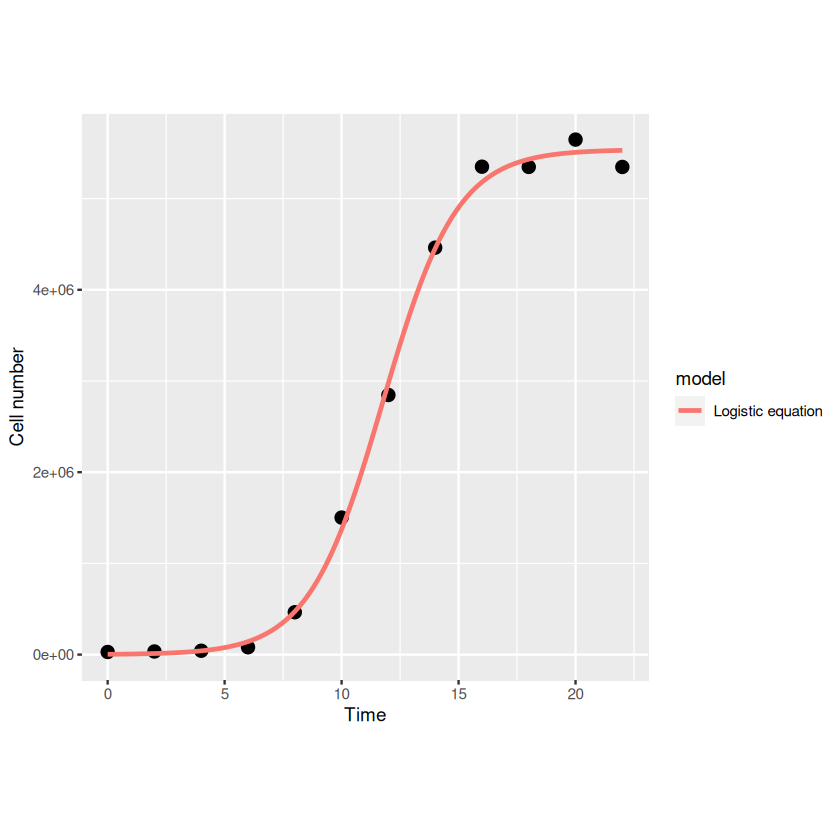

In [77]:
timepoints <- seq(0, 22, 0.1)

logistic_points <- logistic_model(t = timepoints, 
         r_max = coef(fit_logistic)["r_max"], 
         K = coef(fit_logistic)["K"], 
         N_0 = coef(fit_logistic)["N_0"])
df1 <- data.frame(timepoints, logistic_points)
df1$model <- "Logistic equation"
names(df1) <- c("Time", "N", "model")

ggplot(data, aes(x = Time, y = N)) +
 geom_point(size = 3) +
 geom_line(data = df1, aes(x = Time, y = N, col = model), size = 1) +
 theme(aspect.ratio=1)+ # make the plot square 
 labs(x = "Time", y = "Cell number")

That looks nice, and the $r_{max}$ estimate we get (0.64) is fairly close to what we got above with OLS fitting. 

Note that we've done this fitting to the original non transformed data, whilst the linear regressions earlier were on log transformed data. What would this function look like on a log-transformed axis?

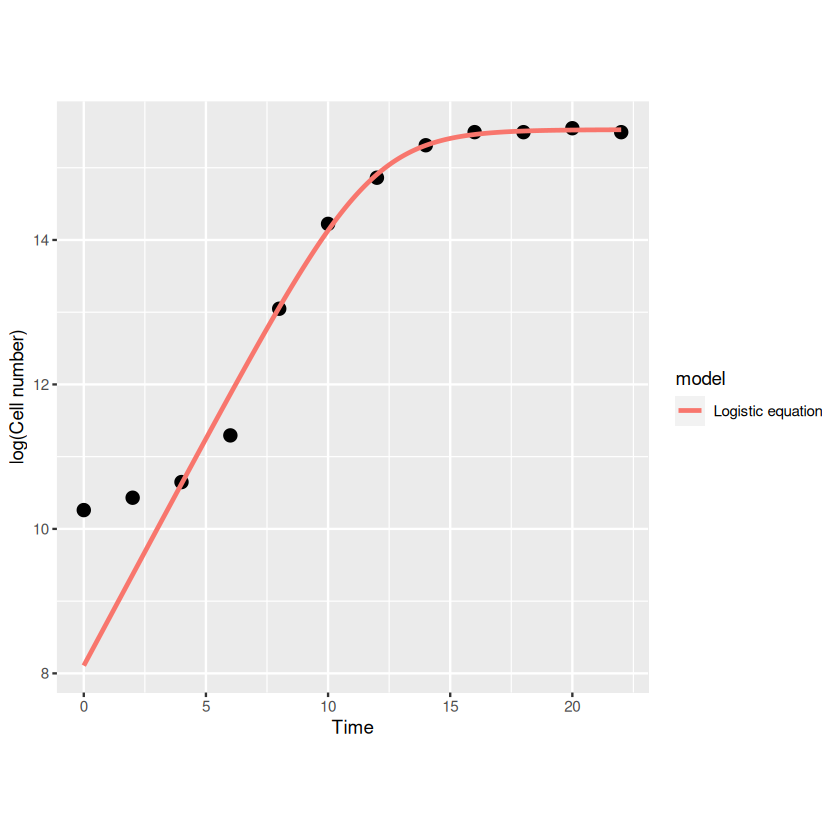

In [78]:
ggplot(data, aes(x = Time, y = LogN)) +
 geom_point(size = 3) +
 geom_line(data = df1, aes(x = Time, y = log(N), col = model), size = 1) +
 theme(aspect.ratio=1)+ 
 labs(x = "Time", y = "log(Cell number)")

The model actually diverges from the data at the lower end! This was not visible in the previous plot where you examined the model in linear scale (without taking a log) because the deviation of the model is small, and only becomes clear in the log scale. This is because of the way logarithms work. Let's have a look at this in our Cell counts "data":

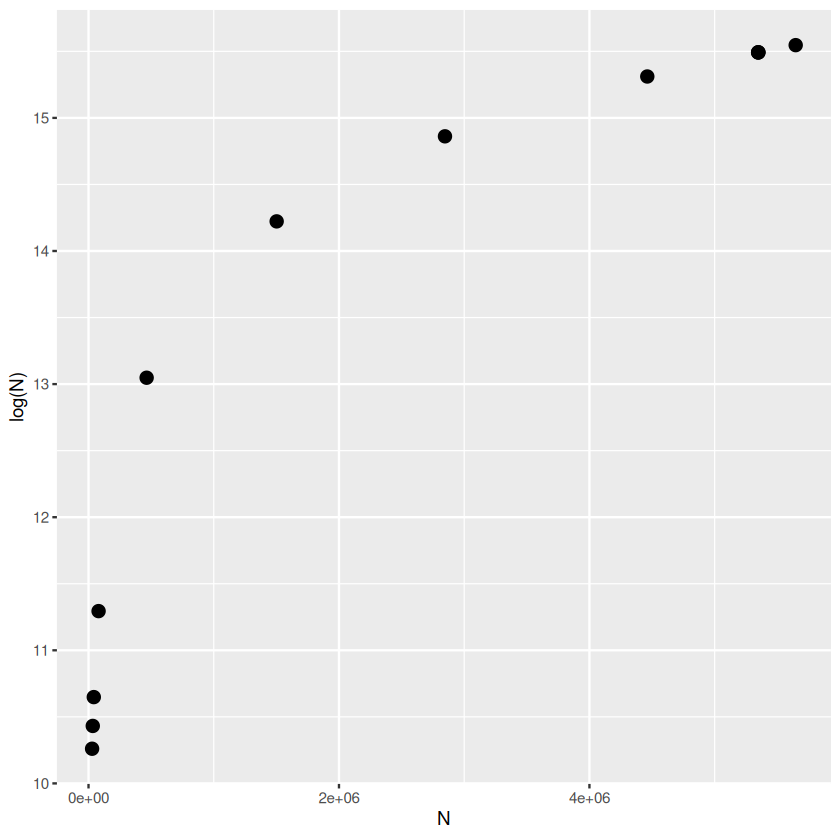

In [79]:
ggplot(data, aes(x = N, y = LogN)) +
 geom_point(size = 3) +
 theme(aspect.ratio = 1)+ 
 labs(x = "N", y = "log(N)")

As you can see the logarithm is a strongly nonlinear transformation of any sequence of real numbers, with small numbers close to zero yielding disproportionately large deviations.

```{note} 
You may play with increasing the error (by increasing the value of `sd` in synthetic data generation step above) and re-evaluating all the subsequent model fitting steps above. However, note that above some values of `sd`, you will start to get negative values of populations, especially at early time points, which will raise issues with taking a logarithm.
```

The above seen deviation of the Logistic model from the data is because this model assumes that the population is growing right from the start (Time = 0), while in "reality" (in our synthetic "data"), this is not what's happening; the population takes a while to grow truly exponentially (i.e., there is a time lag in the population growth). This time lag is seen frequently in the lab, and is also expected in nature, because when bacteria encounter fresh growth media (in the lab) or a new resource/environment (in the field), they take some time to acclimate, activating genes involved in nutrient uptake and metabolic processes, before beginning exponential growth. This is called the lag phase and can be seen in our example data where exponential growth doesn't properly begin until around the 4th hour.

To capture the lag phase, more complicated bacterial growth models have been designed. 

One of these is the modified Gompertz model (Zwietering et. al., 1990), which has been used frequently in the literature to model bacterial growth:

$$ 
  \log(N_t) = N_0 + (N_{max} - N_0) e^{-e^{r_{max} \exp(1) \frac{t_{lag} - t}{(N_{max} - N_0) \log(10)} + 1}}
$$(eq:Gompertz)

Here maximum growth rate ($r_{max}$) is the tangent to the inflection point, $t_{lag}$ is the x-axis intercept to this tangent (duration of the delay before the population starts growing exponentially) and $\log\left(\frac{N_{max}}{N_0}\right)$ is the asymptote of the log-transformed population growth trajectory, i.e., the log ratio of maximum population density $N_{max}$ (aka "carrying capacity") and initial cell (Population) $N_0$ density.

```{note}
Note that unlike the Logistic growth model above, the Gompertz model is in the log scale. This is because the model is not derived from a differential equation, but was designed * specifically * to be fitted to log-transformed data.
```

Now let's fit and compare the two alternative nonlinear growth models: Logistic and Gompertz. 

First, specify the function object for the Gompertz model (we already defined the function for the Logistic model above):

In [80]:
gompertz_model <- function(t, r_max, K, N_0, t_lag){ # Modified gompertz growth model (Zwietering 1990)
 return(N_0 + (K - N_0) * exp(-exp(r_max * exp(1) * (t_lag - t)/((K - N_0) * log(10)) + 1)))
}   

Again, note that unlike the Logistic growth function above, this function has been written in the log scale. 

Now let's generate some starting values for the nlls fitting of the Gompertz model. 

As we did above for the logistic equation, let's derive the starting values by using the actual data: 

In [81]:
N_0_start <- min(data$LogN) # lowest population size, note log scale
K_start <- max(data$LogN) # highest population size, note log scale
r_max_start <- 0.62 # use our previous estimate from the OLS fitting from above
t_lag_start <- data$Time[which.max(diff(diff(data$LogN)))] # find last timepoint of lag phase

 * So how did we find a reasonable time lag from the data? * 

Let's break the last command down:

In [82]:
diff(data$LogN) # same as what we did above - get differentials

[1]  0.171269154  0.216670872  0.646099643  1.753448393  1.174704941
 [6]  0.639023868  0.449529740  0.181493482 -0.000450184  0.054490710
[11] -0.054600924

In [83]:
diff(diff(data$LogN)) # get the differentials of the differentials (approx 2nd order derivatives)

[1]  0.04540172  0.42942877  1.10734875 -0.57874345 -0.53568107 -0.18949413
 [7] -0.26803626 -0.18194367  0.05494089 -0.10909163

In [84]:
which.max(diff(diff(data$LogN))) # find the timepoint where this 2nd order derivative really takes off 

[1] 3

In [85]:
data$Time[which.max(diff(diff(data$LogN)))] # This then is a good guess for the last timepoint of the lag phase

[1] 4

Now fit the model using these start values:

In [86]:
fit_gompertz <- nlsLM(LogN ~ gompertz_model(t = Time, r_max, K, N_0, t_lag), data,
      list(t_lag=t_lag_start, r_max=r_max_start, N_0 = N_0_start, K = K_start))

You might one or more warning(s) that the model fitting iterations generated NaNs during the fitting procedure for these data (because at some point the nlls fitting algorithm "wandered" to a combination of K and N_0 values that yields a NaN for log(K/N_0)). 

You can ignore these warning in this case. But not always &ndash; sometimes these NaNs mean that the equation is wrongly written, or that it generates NaNs across the whole range of the x-values, in which case the model is inappropriate for these data.   

Get the model summary:

In [87]:
summary(fit_gompertz)


Formula: LogN ~ gompertz_model(t = Time, r_max, K, N_0, t_lag)

Parameters:
      Estimate Std. Error t value Pr(>|t|)    
t_lag  4.80680    0.18433   26.08 5.02e-09 ***
r_max  1.86616    0.08749   21.33 2.45e-08 ***
N_0   10.39142    0.05998  173.24 1.38e-15 ***
K     15.54956    0.05056  307.57  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.09418 on 8 degrees of freedom

Number of iterations to convergence: 10 
Achieved convergence tolerance: 1.49e-08


And see how the fits of the two nonlinear models compare:

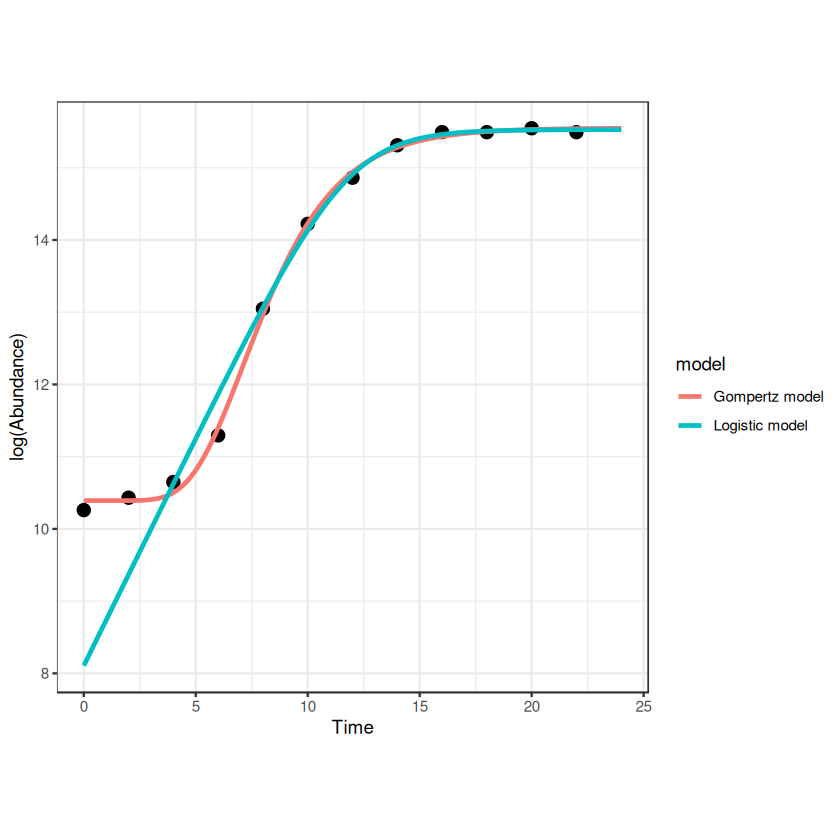

In [88]:
timepoints <- seq(0, 24, 0.1)

logistic_points <- log(logistic_model(t = timepoints, 
          r_max = coef(fit_logistic)["r_max"], 
          K = coef(fit_logistic)["K"], 
          N_0 = coef(fit_logistic)["N_0"]))

gompertz_points <- gompertz_model(t = timepoints, 
         r_max = coef(fit_gompertz)["r_max"], 
         K = coef(fit_gompertz)["K"], 
         N_0 = coef(fit_gompertz)["N_0"], 
         t_lag = coef(fit_gompertz)["t_lag"])

df1 <- data.frame(timepoints, logistic_points)
df1$model <- "Logistic model"
names(df1) <- c("Time", "LogN", "model")

df2 <- data.frame(timepoints, gompertz_points)
df2$model <- "Gompertz model"
names(df2) <- c("Time", "LogN", "model")

model_frame <- rbind(df1, df2)

ggplot(data, aes(x = Time, y = LogN)) +
 geom_point(size = 3) +
 geom_line(data = model_frame, aes(x = Time, y = LogN, col = model), size = 1) +
 theme_bw() + # make the background white
 theme(aspect.ratio=1)+ # make the plot square 
 labs(x = "Time", y = "log(Abundance)")

Clearly, the Gompertz model fits way better than the logistic growth equation in this case! Note also that there is a big difference in the fitted value of $r_{max}$ from the two models; the value is much lower from the Logistic model because it ignores the lag phase, including it into the exponential growth phase. 

You can now perform model selection like you did above in the allometric scaling example. 

### Exercises

(a) Calculate the confidence intervals on the parameters of each of the two fitted models, and use model selection (using AIC and/or BIC) as you did before to see if you can determine the best-fitting model among the three.

(b) Alternatively, for a different random sequence of fluctuations, one or more of the models may fail to fit (a `singular gradiant matrix` error). Try repeating the above fitting with a different random seed (change the integers given to the `random.seed( )` function), or increase the sampling error by increasing the standard deviation and see if it happens. If/when the nlls optimization does fail to converge (the rSS minimum was not found), you can try to fix it by changing the starting values. 

(c) repeat the model comparison exercise 1000 times (You will have to write a loop), and determine if/whether one model generally wins more often than the others. Note that each run will generate a slightly different dataset, because we are adding a vector of random errors every time the "data" are generated. This may result in failure of the nlls fitting to converge, in which case you will need to use the [`try()` or `tryCatch` functions](https://nbviewer.jupyter.org/github/mhasoba/TheMulQuaBio/blob/master/notebooks/r.ipynb).

(d) repeat (b), but increase the error by increasing the standard deviation of the normal error distribution, and see if there are differences in the robustness of the models to sampling/experimental errors. You may also want to try changing the distribution of the errors to some non-normal distribution and see what happens.

## Some tips and tricks for nlls fitting 

(Model-Fitting-nlls-Starting-Values)=
### Starting values 

The main challenge for nlls fitting is finding starting (initial) values for the parameters, which the algorithm needs to proceed with the fitting/optimization. Inappropriate starting values can result in the algorithm finding parameter combinations represent convergence to a local optimum rather than the (globally) optimal solution. Starting parameter estimates can also result in or complete "divergence", i.e., the search results in a combination of parameters that cause mathematical "singularity" (e.g., log(0) or division by zero).

#### Obtaining them 

Finding the starting values is a [bit of an art](https://en.wikipedia.org/wiki/Non-linear_least_squares#Initial_parameter_estimates). There is no method for finding starting values that works universally (across different types of models). 

The one universal rule though, is that finding starting values requires you to understand the meaning of each of the parameters in your model. So, for example, in the population [growth rate example](Model-Fitting-r-Population-Growth), the parameters in both the nonlinear models that [we covered](Model-Fitting-r-Population-Growth) (Logistic growth, eqn. {eq}`eq:logist_growth_sol` , Gompertz model; eqn. {eq}`eq:Gompertz`) have a clear meaning.

Furthermore, you will typically need to determine starting values *specific* to each model *and* each dataset that that you are wanting to fit that model to (e.g., every distinct functional response dataset to be [fitted to the Holling Type II model](Miniproject-Fr-Models)). To do so, understanding how each parameter in the model corresponds to features of the actual data is really necessary. 

For example, in the Gompertz population growth rate model (eqn. {eq}`eq:Gompertz`), your starting values generator function would, for each dataset,   
*  Calculate a starting value for $r_{max}$ by searching for the steepest slope of the growth curve (e.g., with a rolling OLS regression)
* Calculate a starting value of $t_{lag}$ by intersecting the fitted line with the x (time)-axis 
* Calculate a starting value for the asymptote $K$ as the highest data (abundance) value in the dataset. 

```{tip}
Ideally, you should write a separate a function that calculates starting values for the model parameters.
```

#### Sampling them

Once you have worked out how to generate starting values for each non-linear model and dataset, a good next step for optimizing the fitting across multiple datasets (and thus maximize how many datasets are successfully fitted to the model) is to *rerun fitting attempts multiple times, sampling each of the starting values (simultaneously) randomly* (that is, randomly vary the set of starting values a bit each time). This sampling of starting values will increase the likelihood of the nlls optimization algorithm finding a solution (optimal combination of parameters), and not getting stuck in a combination of parameters somewhere far away from that optimal solution. 

In particular, 
* You can choose a Gaussian/Normal distribution if you have high confidence in mean value of parameter, or
* You can uniform distribution if you have low confidence in the mean, but higher confidence in the range of values that the parameter can take.
In both cases, the *mean* of the sampling distribution will be the starting value you inferred from the model and the data (previous section).

Furthermore,
* Whichever distribution you choose (gaussian vs uniform), you will need to determine what range of values to restrict each parameter's samples to. In the case of the normal distribution, this is determined by what standard deviation parameter (you choose), and in the case of the uniform distribution, this is determined by what lower and upper bound (you choose). Generally, a good approach is to set the bound to be some *percent* (say 5-10%) of the parameter's (mean) starting value. In both cases the chosen range to restrict the sampling to would typically be some subset of the model's *parameter bounds* (next section).  
* *How many times to re-run* the fitting for a single dataset and model?* &ndash; this depends on how "difficult" the model is, and how much computational power you have. 

```{tip}
For the sampling of starting values, recall that you learned to generate random numbers from probability distributions in both the [r](r-random-numbers) and [python](python-scipy-stats) chapters). 
```
You may also try and use a more sophisticated approach such as [grid searching](https://en.wikipedia.org/wiki/Hyperparameter_optimization#Approaches) for varying your starting values randomly. An example is in the [mle chapter](mle-LikelihoodSurface).

### Bounding parameters revisited

At the start, we looked at an [example](nlls:Bounding) of nlls fitting where we bounded the parameters. It can be a good idea to restrict the range of values that the each of the model's parameters can take *during any one fitting/optimization run*. To "bound" a parameter in this way means to give it upper and lower limits. By doing so, during one optimization/fitting (e.g., one call to `nlsLM`, to fit one model, to one dataset), the fitting algorithm does not allow a parameter to go outside some limits. This reduces the chances of the optimization getting stuck too far from the solution, or failing completely due to some mathematical singularity (e.g., log(0)).

The bounds are typically fixed for each parameter of a model *at the level of the model* (e.g., they do not change based on each dataset). For example, in the Gompertz model for growth rates (eqn. {eq}`eq:Gompertz`), you can limit the growth rate parameter to never be negative (the bounds would be $[0,\infty]$), or restrict it further to be some value between zero and an upper limit (say, 10) that you know organismal growth rates cannot exceed (the bounds would in this case would be $[0,10]$). 

However, as we saw in the Michaelis-Menten model fitting [example](nlls:Bounding), bounding the parameters too much (excessively narrow ranges) can result in poor solutions because the algorithm cannot explore sufficient parameter space.   

```{tip}
The values of the parameter bounds you choose, of course, may depend on the *units of measurement* of the data. For example, in [SI](https://en.wikipedia.org/wiki/International_System_of_Units), growth rates in the Logistic or Gompertz models would be in units of s$^{-1}$).
```
Irrespective of which computer language the nlls fitting algorithm is implemented in (`nlsLM`  in R or `lmfit` in Python), the fitting command/method will have options for setting the parameter bounds. In particular,

* For `nlsLM` in R, look up https://www.rdocumentation.org/packages/minpack.lm/versions/1.2-1/topics/nlsLM (the `lower` and `upper` arguments to the function). 

* For `lmfit` in Python, look up https://lmfit.github.io/lmfit-py/parameters.html (and in particular, https://lmfit.github.io/lmfit-py/parameters.html#lmfit.parameter.Parameter) (the `min` and `max` arguments).

*Bounding the parameter values has nothing to do, per se, with sampling the starting values of each parameter, though if you choose to sample starting values (explained in previous section), you need to make sure that the samples don't exceed the pre-set bounds (explained in this section).*

```{note}
python's `lmfit` has an option to also internally vary the parameter. So by using a sampling approach as described in the previous section, *and* allowing the parameter to vary (note that `vary=True` is the default) within `lmfit`, you will be in essence be imposing sampling twice. This may or may not improve fitting performance &ndash; try it out both ways.
```

## Readings and resources
 
* Motulsky, Harvey, and Arthur Christopoulos. Fitting models to biological data using linear and nonlinear regression: a practical guide to curve fitting. OUP USA, 2004: <https://www.facm.ucl.ac.be/cooperation/Vietnam/WBI-Vietnam-October-2011/Modelling/regressionBook.pdf>

* These are a pretty good series of notes on nlls (even if you are using R instead of Python): <https://lmfit.github.io/lmfit-py/intro.html>

* Another technical description of nlls  algorithms: <https://www.gnu.org/software/gsl/doc/html/nls.html>

* Johnson, J. B. & Omland, K. S. 2004 Model selection in ecology and evolution. Trends Ecol. Evol. 19, 101–108.

* The *nlstools* package for nlls fit diagnostics: <https://rdrr.io/rforge/nlstools>
    * The original paper: <http://dx.doi.org/10.18637/jss.v066.i05>